In [1]:
!!pip install ruptures

['Requirement already satisfied: ruptures in /usr/local/lib/python3.11/dist-packages (1.1.10)',
 'Requirement already satisfied: numpy in /usr/local/lib/python3.11/dist-packages (from ruptures) (2.4.2)',
 'Requirement already satisfied: scipy in /usr/local/lib/python3.11/dist-packages (from ruptures) (1.17.0)',
 "\x1bWARNING: Running pip as the 'root' user can result in broken permissions and conflicting behaviour with the system package manager, possibly rendering your system unusable.It is recommended to use a virtual environment instead: https://pip.pypa.io/warnings/venv. Use the --root-user-action option if you know what you are doing and want to suppress this warning.\x1b\x1b",
 '\x1b',
 '\x1b[\x1b\x1bnotice\x1b\x1b[1;39;49m]\x1b\x1b A new release of pip is available: \x1b\x1b24.2\x1b\x1b -> \x1b\x1b26.0.1\x1b',
 '\x1b[\x1b\x1bnotice\x1b\x1b[1;39;49m]\x1b\x1b To update, run: \x1b\x1bpython -m pip install --upgrade pip\x1b']

In [2]:
!pip install pandas


[notice] A new release of pip is available: 24.2 -> 26.0.1
[notice] To update, run: python -m pip install --upgrade pip


In [3]:
!pip install scikit-learn


[notice] A new release of pip is available: 24.2 -> 26.0.1
[notice] To update, run: python -m pip install --upgrade pip


In [4]:
!pip install plotly


[notice] A new release of pip is available: 24.2 -> 26.0.1
[notice] To update, run: python -m pip install --upgrade pip


In [5]:
# ===== Cell 0: 安裝必要套件 =====
!pip install openpyxl ruptures


[notice] A new release of pip is available: 24.2 -> 26.0.1
[notice] To update, run: python -m pip install --upgrade pip


In [6]:
# ===== Cell 1: 載入必要套件 =====
import pandas as pd
import numpy as np
import glob
import os

# ===== Cell 2: 快速載入器（C 方案：baseline 用 air 統計值，不做逐點相減）=====
class QuickLoader:
    """簡化版載入器，直接產生 arduino_features
    
    ✅ C 方案修正：
    - 原本用 pine_df[i] - air_df[i] (逐點對齊相減) 是不合理的：
      因為 air 與 pineapple 是不同時間段量測，i 並不代表同一時刻/同一條件。
    - 改為：pine - baseline_air_stat（預設 mean，可改 median）
      讓 delta 表示「相對於該次 air baseline 的偏移」，更穩定、更符合實驗流程。
    """
    
    def __init__(self, data_dir='data/raw', baseline_mode='mean'):
        self.data_dir = data_dir
        self.sensor_cols = ['MQ2_raw', 'MQ3_raw', 'MQ9_raw', 'MQ135_raw', 'TGS2602_raw']

        # baseline_mode: 'mean' 或 'median'（median 對 outlier 更穩）
        self.baseline_mode = baseline_mode
        
        # R0 校正參考值（你原本的）
        self.R0_reference = {
            'MQ2_raw': 10.0,
            'MQ3_raw': 60.0,
            'MQ9_raw': 9.8,
            'MQ135_raw': 76.63,
            'TGS2602_raw': 2.5
        }
    
    def load_and_process(self):
        """一次性載入並處理到 arduino_features"""
        print("🔧 快速處理模式...")
        
        # 1. 載入所有檔案
        air_data, pineapple_data = self._load_files()
        
        if not pineapple_data:
            print("❌ 找不到鳳梨數據")
            return None
        
        # 2. 計算 Arduino 特徵
        arduino_features = self._calculate_features(air_data, pineapple_data)
        
        print(f"✅ 完成！產生 {len(arduino_features)} 顆鳳梨的特徵")
        return arduino_features
    
    def _load_files(self):
        """載入 Excel 檔案"""
        xlsx_files = glob.glob(os.path.join(self.data_dir, '*.xlsx'))
        print(f"📂 找到 {len(xlsx_files)} 個檔案")
        
        air_data = {}
        pineapple_data = {}
        
        for file_path in xlsx_files:
            filename = os.path.basename(file_path)
            parts = filename.replace('.xlsx', '').split('_')
            
            if len(parts) < 3:
                continue
            
            is_air = 'air' in filename
            
            # 讀取檔案
            try:
                # 嘗試跳過第一行
                df = pd.read_excel(file_path, engine='openpyxl', skiprows=1)
                
                # 檢查是否有正確的欄位
                if 'timestamp_ms' not in df.columns:
                    df = pd.read_excel(file_path, engine='openpyxl')
                
                # 轉換數字型別
                for col in self.sensor_cols + ['timestamp_ms']:
                    if col in df.columns:
                        df[col] = pd.to_numeric(df[col], errors='coerce')
                
                # 清理缺值
                df = df.dropna().reset_index(drop=True)
                
            except Exception as e:
                print(f"⚠️  載入失敗 {filename}: {e}")
                continue
            
            # 分類儲存
            if is_air:
                if len(parts) == 3:
                    # 共用 air：xxx_YYYYMMDD_air.xlsx 之類
                    date = parts[1]
                    air_data[f"shared_{date}"] = df
                else:
                    # 專屬 air：xxx_PineappleXX_YYYYMMDD_air.xlsx 之類
                    pid = parts[1]
                    date = parts[2]
                    air_data[f"{pid}_{date}"] = df
            else:
                # pineapple：xxx_PineappleXX_YYYYMMDD_pineapple.xlsx 之類
                pid = parts[1]
                date = parts[2]
                
                if pid not in pineapple_data:
                    pineapple_data[pid] = {}
                pineapple_data[pid][date] = df
        
        print(f"   ✓ Air: {len(air_data)}, Pineapple: {len(pineapple_data)} 顆")
        return air_data, pineapple_data
    
    def _air_baseline_value(self, air_df, col):
        """計算 air baseline 統計值（mean 或 median）"""
        if col not in air_df.columns:
            return np.nan
        s = pd.to_numeric(air_df[col], errors='coerce').dropna()
        if len(s) == 0:
            return np.nan
        if self.baseline_mode == 'median':
            return float(s.median())
        return float(s.mean())
    
    def _calculate_features(self, air_data, pineapple_data):
        """計算 Arduino 特徵（C 方案：delta 使用 air baseline 統計值）"""
        arduino_features = {}
        
        for pid, date_dict in pineapple_data.items():
            arduino_features[pid] = {}
            
            for date, pine_df in date_dict.items():
                # 找對應的 air baseline
                air_df = self._get_air(air_data, pid, date)
                
                if air_df is None:
                    print(f"⚠️  {pid}_{date} 找不到 air baseline")
                    continue
                
                # ✅ C：不做逐點相減，改成用 air baseline 的統計值
                delta_df = pine_df.copy()
                
                for col in self.sensor_cols:
                    if col in pine_df.columns and col in air_df.columns:
                        base_val = self._air_baseline_value(air_df, col)
                        if np.isnan(base_val):
                            continue
                        delta_df[f'{col}_delta'] = pine_df[col].values - base_val
                
                # 計算 Arduino 特徵
                features_df = delta_df.copy()
                
                for col in self.sensor_cols:
                    if col in delta_df.columns:
                        sensor_name = col.replace('_raw', '')
                        R0 = self.R0_reference.get(col, 10.0)
                        
                        # Rs/R0（用 raw / R0，這裡保持你原本寫法）
                        features_df[f'{sensor_name}_Rs_R0'] = delta_df[col] / R0
                        
                        # Delta Rs/R0（delta / R0）
                        delta_col = f'{col}_delta'
                        if delta_col in delta_df.columns:
                            features_df[f'{sensor_name}_delta_Rs_R0'] = delta_df[delta_col] / R0
                        
                        # 移動平均（raw）
                        features_df[f'{sensor_name}_ma10'] = (
                            delta_df[col].rolling(window=10, center=True).mean()
                        )
                        
                        # 移動標準差（raw）
                        features_df[f'{sensor_name}_std10'] = (
                            delta_df[col].rolling(window=10, center=True).std()
                        )
                
                arduino_features[pid][date] = features_df
                print(f"   ✓ {pid}_{date}: {features_df.shape}")
        
        return arduino_features
    
    def _get_air(self, air_data, pid, date):
        """取得對應的 air baseline"""
        # 專屬 air
        key = f"{pid}_{date}"
        if key in air_data:
            return air_data[key]
        
        # 共用 air
        shared_key = f"shared_{date}"
        if shared_key in air_data:
            return air_data[shared_key]
        
        return None

# 執行載入
loader = QuickLoader('data/raw', baseline_mode='mean')  # 你也可改 'median'
arduino_features = loader.load_and_process()


🔧 快速處理模式...
📂 找到 214 個檔案
   ✓ Air: 105, Pineapple: 11 顆
   ✓ 11_20260213: (900, 54)
   ✓ 11_20260212: (900, 54)
   ✓ 11_20260211: (900, 54)
   ✓ 11_20260210: (900, 54)
   ✓ 11_20260209: (900, 54)
   ✓ 11_20260208: (900, 54)
   ✓ 10_20260213: (900, 54)
   ✓ 10_20260212: (900, 54)
   ✓ 10_20260211: (900, 54)
   ✓ 10_20260210: (900, 54)
   ✓ 10_20260209: (900, 54)
   ✓ 10_20260208: (900, 54)
   ✓ 09_20260219: (900, 54)
   ✓ 09_20260217: (900, 54)
   ✓ 09_20260215: (900, 54)
   ✓ 09_20260214: (900, 54)
   ✓ 09_20260213: (900, 54)
   ✓ 09_20260212: (900, 54)
   ✓ 09_20260209: (900, 50)
   ✓ 09_20260208: (900, 50)
   ✓ 09_20260207: (900, 50)
   ✓ 08_20260213: (900, 50)
   ✓ 08_20260212: (900, 50)
   ✓ 08_20260211: (900, 50)
   ✓ 08_20260210: (900, 50)
   ✓ 08_20260209: (900, 50)
   ✓ 08_20260208: (900, 50)
   ✓ 08_20260207: (900, 50)
   ✓ 08_20260206: (900, 50)
   ✓ 08_20260205: (900, 50)
   ✓ 08_20260204: (900, 50)
   ✓ 08_20260203: (900, 50)
   ✓ 07_20260213: (900, 50)
   ✓ 07_20260212: (9

In [7]:
# ===== Cell 9（A2 + B）：基於物理規律的標籤定義（逐筆 proxy + robust 分段）=====

import numpy as np
import pandas as pd
from scipy.ndimage import gaussian_filter1d

class PhysicsBasedLabeling:
    """用物理約束代替人工標註（A2 + B）
    
    ✅ A2 修正：
    - 原本 proxy 是「每一天一個值」→ labels 長度 = 天數
    - 但 FeatureEngineer 是把每一天的 df 串成「逐筆資料」→ X 長度 = 900*天數
    - 長度不一致會被截斷到只剩幾筆 → 準確率崩潰
    
    現在改成：
    - 將所有天的資料串接後，對每一筆 row 計算 maturity_proxy
    - labels 長度 = combined_df 長度（與 X 完全一致）
    
    ✅ B 修正：
    - percentiles 切 4 段在「數值幾乎相同」或「threshold 重疊」會全變同一 stage
    - 加入 robust 防呆：
      1) 若數值幾乎常數 / threshold 重疊 → 改用「時間均分(索引均分)」切 4 段
      2) 確保至少能產生多階段（避免熵=0）
    """
    
    def __init__(self, arduino_features):
        self.arduino_features = arduino_features
        self.key_sensors = ['MQ135', 'TGS2602']  # 你原本的關鍵感測器
        
    def generate_labels(self):
        """主流程：對每顆鳳梨產生逐筆 labels"""
        all_labels = {}
        
        for pid in self.arduino_features.keys():
            print(f"🍍 處理鳳梨 {pid}...")
            
            # Step 1: 組合所有天的資料（順序一定要和 FeatureEngineer 一致：sorted(date)）
            combined_df, date_index = self._concat_by_date(pid)
            if combined_df is None or len(combined_df) == 0:
                print(f"   ⚠️ {pid} 無可用資料，跳過")
                continue
            
            # Step 2: 逐筆計算成熟度代理指標（A2 核心）
            maturity_proxy = self._compute_maturity_proxy_per_sample(combined_df)
            
            # Step 3: 平滑處理（消除噪音）
            maturity_smooth = self._smooth_curve(maturity_proxy)
            
            # Step 4: 強制單調性（物理約束：成熟度不應「變生」）
            maturity_monotonic = self._enforce_monotonic(maturity_smooth)
            
            # Step 5: robust 映射到 4 階段（B 核心）
            stages = self._map_to_4_stages_robust(maturity_monotonic)
            
            # Step 6: 驗證；若仍異常，fallback 用索引均分
            if not self._validate_labels(stages):
                print(f"   ⚠️ {pid} 標籤異常，使用 fallback（索引均分 4 段）")
                stages = self._fallback_labels_by_index(len(combined_df))
            
            all_labels[pid] = stages
        
        return all_labels

    # ---------- A2：把所有天數據串起來（順序要一致） ----------
    def _concat_by_date(self, pid):
        """將 pid 的多天資料按日期排序後 concat，回傳 combined_df 與 (date, start,end)索引資訊"""
        dates = sorted(self.arduino_features[pid].keys())
        if len(dates) == 0:
            return None, None
        
        df_list = []
        date_index = []
        cursor = 0
        
        for d in dates:
            df = self.arduino_features[pid][d]
            if df is None or len(df) == 0:
                continue
            n = len(df)
            df_list.append(df.reset_index(drop=True))
            date_index.append({'date': d, 'start': cursor, 'end': cursor + n})
            cursor += n
        
        if len(df_list) == 0:
            return None, None
        
        combined_df = pd.concat(df_list, ignore_index=True)
        return combined_df, date_index

    # ---------- A2：逐筆 proxy ----------
    def _compute_maturity_proxy_per_sample(self, combined_df):
        """逐筆計算成熟度代理指標（每一列都會有一個 proxy 值）
        
        proxy = 0.4*MQ135_Rs_R0 + 0.6*TGS2602_Rs_R0
        - 若欄位不存在，會自動降級（只用存在的那個）
        """
        # 取欄位（若缺就用 0）
        mq135 = combined_df['MQ135_Rs_R0'] if 'MQ135_Rs_R0' in combined_df.columns else None
        tgs2602 = combined_df['TGS2602_Rs_R0'] if 'TGS2602_Rs_R0' in combined_df.columns else None
        
        if mq135 is None and tgs2602 is None:
            # 沒有關鍵欄位就只能用全 0（但這代表資料不完整）
            return np.zeros(len(combined_df), dtype=float)
        
        if mq135 is None:
            proxy = 1.0 * pd.to_numeric(tgs2602, errors='coerce').fillna(0).values
        elif tgs2602 is None:
            proxy = 1.0 * pd.to_numeric(mq135, errors='coerce').fillna(0).values
        else:
            mq135_v = pd.to_numeric(mq135, errors='coerce').fillna(0).values
            tgs_v = pd.to_numeric(tgs2602, errors='coerce').fillna(0).values
            proxy = 0.4 * mq135_v + 0.6 * tgs_v
        
        return proxy.astype(float)

    # ---------- 平滑 ----------
    def _smooth_curve(self, values):
        """高斯平滑（消除感測器噪音）"""
        values = np.asarray(values, dtype=float)
        if len(values) < 5:
            return values
        
        # sigma=2：比你原本更穩一點（900 筆等級很適合）
        smoothed = gaussian_filter1d(values, sigma=2)
        return smoothed

    # ---------- 單調約束 ----------
    def _enforce_monotonic(self, values):
        """強制單調遞增（成熟度不應倒退）"""
        values = np.asarray(values, dtype=float)
        monotonic = values.copy()
        for i in range(1, len(monotonic)):
            if monotonic[i] < monotonic[i - 1]:
                monotonic[i] = monotonic[i - 1]
        return monotonic

    # ---------- B：robust 分段 ----------
    def _map_to_4_stages_robust(self, maturity_values):
        """將 maturity_values 映射到 4 階段（robust 版，避免 threshold 重疊造成單一 stage）"""
        v = np.asarray(maturity_values, dtype=float)
        n = len(v)
        if n == 0:
            return np.array([], dtype=int)

        # 情況1：點太少（例如 < 20）→ 直接用索引均分比較穩
        if n < 20:
            return self._fallback_labels_by_index(n)

        # 情況2：數值幾乎常數 → percentiles 沒意義 → 用索引均分
        v_range = float(np.nanmax(v) - np.nanmin(v)) if np.isfinite(v).all() else float(np.nanmax(np.nan_to_num(v)) - np.nanmin(np.nan_to_num(v)))
        if v_range < 1e-9:
            return self._fallback_labels_by_index(n)

        # 一般情況：用分位數切 4 段
        thresholds = np.percentile(v, [25, 50, 75])

        # 情況3：threshold 重疊（例如都一樣）→ 會變成單一 stage → 改索引均分
        if len(np.unique(np.round(thresholds, 12))) < 3:
            return self._fallback_labels_by_index(n)

        stages = np.zeros(n, dtype=int)
        stages[v > thresholds[0]] = 1
        stages[v > thresholds[1]] = 2
        stages[v > thresholds[2]] = 3
        return stages

    def _fallback_labels_by_index(self, n_points):
        """fallback：按照索引把序列均分成 4 段（一定會有多階段，避免熵=0）"""
        if n_points == 0:
            return np.array([], dtype=int)
        idx = np.arange(n_points)
        q1 = int(n_points * 0.25)
        q2 = int(n_points * 0.50)
        q3 = int(n_points * 0.75)

        stages = np.zeros(n_points, dtype=int)
        stages[idx >= q1] = 1
        stages[idx >= q2] = 2
        stages[idx >= q3] = 3
        return stages

    # ---------- 驗證 ----------
    def _validate_labels(self, stages):
        """驗證標籤合理性（逐筆版）"""
        stages = np.asarray(stages, dtype=int)
        if len(stages) == 0:
            return False

        uniq = np.unique(stages)

        # 至少要有 3 種 stage，不然模型沒法學
        if len(uniq) < 3:
            return False

        # 倒退次數（理論上 enforce_monotonic 後應該 = 0）
        reversals = np.sum(stages[1:] < stages[:-1])
        if reversals > 0:
            return False

        return True


# ===== 執行 =====
labeler = PhysicsBasedLabeling(arduino_features)
maturity_labels = labeler.generate_labels()

# ===== 驗證結果 =====
print("\n📊 標籤品質檢查：")
for pid in maturity_labels.keys():
    stages = maturity_labels[pid]
    unique, counts = np.unique(stages, return_counts=True)
    reversals = int(np.sum(stages[1:] < stages[:-1])) if len(stages) > 1 else 0
    
    print(f"  {pid}: {dict(zip(unique, counts))}")
    print(f"       倒退次數: {reversals} ({(reversals/len(stages)*100 if len(stages)>0 else 0):.1f}%)")
    print(f"       涵蓋階段: {len(unique)}/4")


🍍 處理鳳梨 11...
🍍 處理鳳梨 10...
🍍 處理鳳梨 09...
🍍 處理鳳梨 08...
🍍 處理鳳梨 07...
🍍 處理鳳梨 06...
🍍 處理鳳梨 05...
🍍 處理鳳梨 04...
🍍 處理鳳梨 03...
🍍 處理鳳梨 02...
🍍 處理鳳梨 01...

📊 標籤品質檢查：
  11: {np.int64(0): np.int64(1350), np.int64(1): np.int64(1350), np.int64(2): np.int64(1350), np.int64(3): np.int64(1350)}
       倒退次數: 0 (0.0%)
       涵蓋階段: 4/4
  10: {np.int64(0): np.int64(1350), np.int64(1): np.int64(1350), np.int64(2): np.int64(1350), np.int64(3): np.int64(1350)}
       倒退次數: 0 (0.0%)
       涵蓋階段: 4/4
  09: {np.int64(0): np.int64(2025), np.int64(1): np.int64(2025), np.int64(2): np.int64(2025), np.int64(3): np.int64(2025)}
       倒退次數: 0 (0.0%)
       涵蓋階段: 4/4
  08: {np.int64(0): np.int64(3602), np.int64(1): np.int64(1797), np.int64(2): np.int64(2701), np.int64(3): np.int64(1800)}
       倒退次數: 0 (0.0%)
       涵蓋階段: 4/4
  07: {np.int64(0): np.int64(3603), np.int64(1): np.int64(1795), np.int64(2): np.int64(4500)}
       倒退次數: 0 (0.0%)
       涵蓋階段: 3/4
  06: {np.int64(0): np.int64(2024), np.int64(1): np.int64(2025), 

In [8]:
!pip install matplotlib


[notice] A new release of pip is available: 24.2 -> 26.0.1
[notice] To update, run: python -m pip install --upgrade pip


🔬 正在驗證標籤分離度 (PCA)...


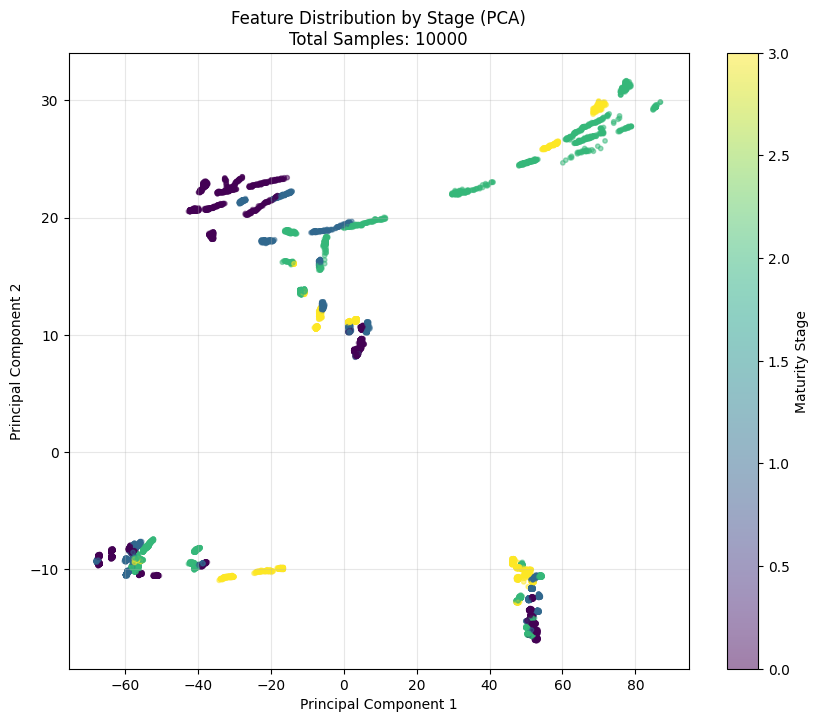

✅ 解讀指南：
1. 如果看到顏色像彩虹一樣漸層分佈 (紫->藍->綠->黃)，表示標籤定義很成功！
2. 如果不同顏色的點混雜在一起 (例如黃色點跑到紫色區)，表示特徵重疊嚴重。


In [9]:
# ===== Cell 9.5: 標籤品質驗證 (PCA 可視化) =====
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

def check_label_quality(features_dict, labels_dict):
    print("🔬 正在驗證標籤分離度 (PCA)...")
    
    all_X = []
    all_y = []
    
    # 1. 收集所有鳳梨的數據
    for pid, date_dict in features_dict.items():
        if pid not in labels_dict: continue
        
        # 組合特徵
        df_list = []
        for date in sorted(date_dict.keys()):
            df_list.append(date_dict[date])
        combined_df = pd.concat(df_list, ignore_index=True)
        
        # 提取感測器數據
        sensor_cols = ['MQ2_Rs_R0', 'MQ3_Rs_R0', 'MQ9_Rs_R0', 'MQ135_Rs_R0', 'TGS2602_Rs_R0']
        cols = [c for c in sensor_cols if c in combined_df.columns]
        
        if not cols: continue
        
        X = combined_df[cols].ffill().bfill().values
        y = labels_dict[pid]
        
        # 確保 X 和 y 長度一致 (有時候可能有微小誤差)
        min_len = min(len(X), len(y))
        all_X.append(X[:min_len])
        all_y.append(y[:min_len])

    if not all_X:
        print("❌ 沒有足夠數據進行驗證")
        return

    # 2. 合併並降維
    X_total = np.vstack(all_X)
    y_total = np.concatenate(all_y)
    
    # 為了速度，如果點太多，隨機抽樣 10000 點來畫圖
    if len(X_total) > 10000:
        idx = np.random.choice(len(X_total), 10000, replace=False)
        X_total = X_total[idx]
        y_total = y_total[idx]

    # PCA 降維到 2D
    pca = PCA(n_components=2)
    X_pca = pca.fit_transform(X_total)
    
    # 3. 畫圖
    plt.figure(figsize=(10, 8))
    scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y_total, cmap='viridis', alpha=0.5, s=10)
    plt.colorbar(scatter, label='Maturity Stage')
    plt.title(f'Feature Distribution by Stage (PCA)\nTotal Samples: {len(X_total)}')
    plt.xlabel('Principal Component 1')
    plt.ylabel('Principal Component 2')
    plt.grid(True, alpha=0.3)
    plt.show()
    
    print("✅ 解讀指南：")
    print("1. 如果看到顏色像彩虹一樣漸層分佈 (紫->藍->綠->黃)，表示標籤定義很成功！")
    print("2. 如果不同顏色的點混雜在一起 (例如黃色點跑到紫色區)，表示特徵重疊嚴重。")

# 執行驗證
check_label_quality(arduino_features, maturity_labels)

In [10]:
# ===== Cell 10: 自動化品質檢查與儲存（安全優化版）===== 

import json
import pickle
import os
import numpy as np
import pandas as pd
from datetime import datetime
from sklearn.metrics import silhouette_score  # 目前可能用不到，但先保留

class AutomatedQualityChecker:
    """全自動品質檢查與標籤驗證"""
    
    def __init__(self, maturity_labels, arduino_features, 
                 changepoint_results=None, clustering_results=None):
        self.maturity_labels = maturity_labels
        self.arduino_features = arduino_features
        # 新版：這兩個改成可選
        self.changepoint_results = changepoint_results or {}
        self.clustering_results = clustering_results or {}
        self.quality_report = {}
        self.output_dir = 'data/processed'
        os.makedirs(self.output_dir, exist_ok=True)
    
    @staticmethod
    def convert_numpy_types(obj):
        """遞迴轉換 numpy 類型為 Python 原生類型 (增強版)"""
        if isinstance(obj, dict):
            return {
                AutomatedQualityChecker.convert_numpy_types(k): 
                AutomatedQualityChecker.convert_numpy_types(v)
                for k, v in obj.items()
            }
        elif isinstance(obj, list):
            return [AutomatedQualityChecker.convert_numpy_types(item) for item in obj]
        elif isinstance(obj, (np.integer, np.int64, np.int32)):
            return int(obj)
        elif isinstance(obj, (np.floating, np.float64, np.float32)):
            return float(obj)
        elif isinstance(obj, np.ndarray):
            return obj.tolist()
        else:
            return obj
    
    def run_full_check(self):
        """執行完整的自動化檢查流程"""
        print("="*60)
        print("🤖 自動化品質檢查")
        print("="*60)
        
        self._check_label_distribution()
        self._check_changepoint_quality()
        self._check_clustering_quality()
        self._auto_fix_issues()
        self._generate_quality_report()
        self._save_final_labels()
        
        print("\n" + "="*60)
        print("✅ Step 3 完全自動化完成！")
        print("="*60)
        
        return self.maturity_labels
    
    def _check_label_distribution(self):
        """檢查標籤分布是否合理"""
        print("\n📊 檢查標籤分布...")
        
        for pid, stages in self.maturity_labels.items():
            unique, counts = np.unique(stages, return_counts=True)
            distribution = {int(k): int(v) for k, v in zip(unique, counts)}
            
            total = len(stages)
            probs = counts / total
            entropy = -np.sum(probs * np.log2(probs + 1e-10))
            max_entropy = np.log2(len(unique)) if len(unique) > 1 else 1
            normalized_entropy = float(entropy / max_entropy) if max_entropy > 0 else 0.0
            
            issues = []
            if len(unique) == 1:
                issues.append("只有單一階段")
            
            max_ratio = max(probs)
            if max_ratio > 0.95:
                issues.append(f"階段分布過於集中({max_ratio*100:.1f}%)")
            
            # 因為我們現在強制分 4 期，entropy 可能會比較低是正常的，這裡放寬標準
            if len(unique) > 1 and normalized_entropy < 0.1: 
                issues.append(f"分布不均勻(熵={normalized_entropy:.2f})")
            
            self.quality_report[pid] = {
                'distribution': distribution,
                'entropy': normalized_entropy,
                'issues': issues,
                'status': 'PASS' if not issues else 'WARNING'
            }
            
            status_icon = "✅" if not issues else "⚠️"
            print(f"   {status_icon} Pineapple {pid}: 階段數={len(distribution)}, 熵={normalized_entropy:.2f}")
    
    def _check_changepoint_quality(self):
        """檢查變化點偵測品質（新版：如果沒有資料就直接略過）"""
        print("\n🔍 檢查變化點品質...")
        
        if not self.changepoint_results:
            print("   ℹ️ 未提供變化點結果（新版 Stage 由 PCA+KMeans 定義），略過此步驟。")
            return
        
        for pid, changepoints in self.changepoint_results.items():
            n_points = len(self.maturity_labels[pid])
            
            # ruptures.predict 會回傳「切點 + 最後一個 len(df)」
            n_raw_cps = len(changepoints)
            n_changepoints = max(0, n_raw_cps - 1)
            
            if n_points > 0:
                cp_density = float(n_changepoints / (n_points / 1000.0))
            else:
                cp_density = 0.0
            
            if n_changepoints == 0:
                status = "無變化點"
            elif cp_density < 0.2:
                status = "變化點稀疏（穩定）"
            elif cp_density > 6:
                status = "變化點密集"
            else:
                status = "正常"
            
            if pid in self.quality_report:
                self.quality_report[pid]['changepoint_density'] = cp_density
                self.quality_report[pid]['changepoint_status'] = status
            
            print(f"   🍍 {pid}: {n_changepoints} 個變化點, {status}")
    
    def _check_clustering_quality(self):
        """檢查 Clustering 品質（新版：如果沒有 clustering_results 就略過）"""
        print("\n🎯 檢查 Clustering 品質...")
        
        if not self.clustering_results:
            print("   ℹ️ 未提供 clustering 結果（新版 Stage 由 PCA+KMeans 定義），略過此步驟。")
            return
        
        for pid, cluster_labels in self.clustering_results.items():
            if pid not in self.arduino_features:
                continue
            
            try:
                all_features = []
                date_dict = self.arduino_features[pid]
                
                # ✅ 跟 Cell 9 / Cell 11 一樣：用排序後的日期順序來合併
                for date in sorted(date_dict.keys()):
                    df = date_dict[date]
                    feature_cols = [f'{s}_Rs_R0' for s in ['MQ2', 'MQ3', 'MQ9', 'MQ135', 'TGS2602']]
                    feature_cols = [col for col in feature_cols if col in df.columns]
                    if feature_cols:
                        X = df[feature_cols].ffill().bfill().values
                        all_features.append(X)
                
                if all_features:
                    X_combined = np.vstack(all_features)
                    
                    # 🔥 採樣計算 Silhouette 以防止當機
                    if len(X_combined) > 5000:
                        idx = np.random.choice(len(X_combined), 5000, replace=False)
                        X_sample = X_combined[idx]
                        labels_sample = cluster_labels[idx]
                    else:
                        X_sample = X_combined
                        labels_sample = cluster_labels
                    
                    if len(np.unique(labels_sample)) > 1:
                        score = float(silhouette_score(X_sample, labels_sample))
                        
                        if score > 0.5:
                            quality = "優秀"
                        elif score > 0.3:
                            quality = "良好"
                        elif score > 0.1:
                            quality = "可接受"
                        else:
                            quality = "較差"
                        
                        if pid in self.quality_report:
                            self.quality_report[pid]['silhouette_score'] = score
                            self.quality_report[pid]['clustering_quality'] = quality
                        
                        print(f"   🍍 {pid}: Silhouette={score:.3f}, 品質={quality}")
                    
            except Exception as e:
                print(f"   ⚠️  {pid}: 無法計算 ({e})")
    
    def _auto_fix_issues(self):
        """自動修正檢測到的問題"""
        print("\n🔧 自動修正...")
        fixed_count = 0
        for pid, report in self.quality_report.items():
            # 如果因為某些原因變化點偵測失敗導致只有1個階段，改用 Clustering 結果
            if report['status'] == 'WARNING' and "只有單一階段" in report['issues']:
                if pid in self.clustering_results:
                    self.maturity_labels[pid] = self.clustering_results[pid]
                    print(f"   🔧 {pid}: 自動替換為 Clustering 結果")
                    fixed_count += 1
                    report['status'] = 'FIXED'
        
        print(f"   ✅ 已自動修正 {fixed_count} 個問題" if fixed_count > 0 else "   ✅ 無需修正")
    
    def _generate_quality_report(self):
        """產生品質報告"""
        print("\n📋 產生品質報告...")
        report_path = os.path.join(self.output_dir, 'step3_quality_report.json')
        quality_report_clean = self.convert_numpy_types(self.quality_report)
        
        report_summary = {
            'timestamp': datetime.now().isoformat(),
            'total_pineapples': len(self.maturity_labels),
            'pineapple_reports': quality_report_clean,
            'overall_status': 'PASS' if all(
                r.get('status') in ['PASS', 'FIXED']
                for r in quality_report_clean.values()
            ) else 'WARNING'
        }
        
        with open(report_path, 'w', encoding='utf-8') as f:
            json.dump(report_summary, f, indent=2, ensure_ascii=False)
        print(f"   💾 品質報告已儲存: {report_path}")
    
    def _save_final_labels(self):
        """儲存最終標籤"""
        print("\n💾 儲存最終標籤...")
        # Pickle
        pkl_path = os.path.join(self.output_dir, 'maturity_labels.pkl')
        with open(pkl_path, 'wb') as f:
            pickle.dump(self.maturity_labels, f)
        print(f"   ✅ Pickle: {pkl_path}")
        
        # JSON
        json_data = self.convert_numpy_types({
            pid: {
                'stages': stages.tolist() if isinstance(stages, np.ndarray) else list(stages),
                'unique_stages': np.unique(stages).tolist()
            } for pid, stages in self.maturity_labels.items()
        })
        with open(os.path.join(self.output_dir, 'maturity_labels.json'), 'w', encoding='utf-8') as f:
            json.dump(json_data, f, indent=2, ensure_ascii=False)
        print(f"   ✅ JSON: maturity_labels.json")
        
        # CSV
        csv_path = os.path.join(self.output_dir, 'maturity_labels_summary.csv')
        summary_data = []
        for pid, stages in self.maturity_labels.items():
            unique, counts = np.unique(stages, return_counts=True)
            for stage, count in zip(unique, counts):
                summary_data.append({
                    'pineapple_id': pid,
                    'stage': int(stage),
                    'count': int(count),
                    'percentage': f"{count / len(stages) * 100:.1f}%"
                })
        pd.DataFrame(summary_data).to_csv(csv_path, index=False, encoding='utf-8-sig')
        print(f"   ✅ CSV: {csv_path}")

# 🔥 執行（新版不再需要 detector）
checker = AutomatedQualityChecker(
    maturity_labels,
    arduino_features
)
final_labels = checker.run_full_check()

print(f"\n🎉 Step 3 完成！可以進入 Step 4（特徵工程）")

# 檢查 Stage 2 分布
print("\n🔥 檢查 Stage 2 (過熟) 分布:")
stage2_total = 0
total_len = 0
for pid, stages in final_labels.items():
    stage2_count = np.sum(stages == 2)
    stage2_total += stage2_count
    total_len += len(stages)
    print(f"  {pid}: Stage 2 = {stage2_count} ({stage2_count/len(stages)*100:.1f}%)")

if total_len > 0:
    print(f"總 Stage 2: {stage2_total}/{total_len} ({stage2_total/total_len*100:.1f}%)")


🤖 自動化品質檢查

📊 檢查標籤分布...
   ✅ Pineapple 11: 階段數=4, 熵=1.00
   ✅ Pineapple 10: 階段數=4, 熵=1.00
   ✅ Pineapple 09: 階段數=4, 熵=1.00
   ✅ Pineapple 08: 階段數=4, 熵=0.97
   ✅ Pineapple 07: 階段數=3, 熵=0.94
   ✅ Pineapple 06: 階段數=4, 熵=1.00
   ✅ Pineapple 05: 階段數=4, 熵=1.00
   ✅ Pineapple 04: 階段數=4, 熵=1.00
   ✅ Pineapple 03: 階段數=3, 熵=0.97
   ✅ Pineapple 02: 階段數=4, 熵=1.00
   ✅ Pineapple 01: 階段數=3, 熵=0.96

🔍 檢查變化點品質...
   ℹ️ 未提供變化點結果（新版 Stage 由 PCA+KMeans 定義），略過此步驟。

🎯 檢查 Clustering 品質...
   ℹ️ 未提供 clustering 結果（新版 Stage 由 PCA+KMeans 定義），略過此步驟。

🔧 自動修正...
   ✅ 無需修正

📋 產生品質報告...
   💾 品質報告已儲存: data/processed/step3_quality_report.json

💾 儲存最終標籤...
   ✅ Pickle: data/processed/maturity_labels.pkl
   ✅ JSON: maturity_labels.json
   ✅ CSV: data/processed/maturity_labels_summary.csv

✅ Step 3 完全自動化完成！

🎉 Step 3 完成！可以進入 Step 4（特徵工程）

🔥 檢查 Stage 2 (過熟) 分布:
  11: Stage 2 = 1350 (25.0%)
  10: Stage 2 = 1350 (25.0%)
  09: Stage 2 = 2025 (25.0%)
  08: Stage 2 = 2701 (27.3%)
  07: Stage 2 = 4500 (45.5%)
  06: Stage 2 = 202

In [11]:
# ===== 分析階段分布 =====

import pandas as pd
import numpy as np

print("="*60)
print("📊 階段分布詳細分析")
print("="*60)

# 載入剛才儲存的標籤
import pickle
with open('data/processed/maturity_labels.pkl', 'rb') as f:
    labels = pickle.load(f)

all_stage_counts = {}

for pid, stages in labels.items():
    unique, counts = np.unique(stages, return_counts=True)
    
    print(f"\n🍍 Pineapple {pid} ({len(stages)} 筆資料):")
    print(f"   階段數: {len(unique)}")
    
    for stage, count in zip(unique, counts):
        percentage = count / len(stages) * 100
        print(f"   Stage {stage}: {count:4d} 筆 ({percentage:5.1f}%)")
        
        # 累計到全局統計
        if stage not in all_stage_counts:
            all_stage_counts[stage] = 0
        all_stage_counts[stage] += count

# 全局統計
print("\n" + "="*60)
print("📊 全局階段分布（所有鳳梨合計）")
print("="*60)

total_samples = sum(all_stage_counts.values())
sorted_stages = sorted(all_stage_counts.items())

for stage, count in sorted_stages:
    percentage = count / total_samples * 100
    print(f"Stage {stage:2d}: {count:5d} 筆 ({percentage:5.1f}%)")

print(f"\n總樣本數: {total_samples}")
print(f"總階段數: {len(all_stage_counts)}")

# 找出樣本數最少的階段
min_stage = min(sorted_stages, key=lambda x: x[1])
max_stage = max(sorted_stages, key=lambda x: x[1])

print(f"\n⚠️  樣本最少階段: Stage {min_stage[0]} ({min_stage[1]} 筆, {min_stage[1]/total_samples*100:.1f}%)")
print(f"✅ 樣本最多階段: Stage {max_stage[0]} ({max_stage[1]} 筆, {max_stage[1]/total_samples*100:.1f}%)")

# 檢查是否有嚴重不平衡
imbalance_ratio = max_stage[1] / min_stage[1]
print(f"\n📊 不平衡比例: {imbalance_ratio:.1f}:1")

if imbalance_ratio > 10:
    print("⚠️  階段分布嚴重不平衡！")
elif imbalance_ratio > 5:
    print("⚠️  階段分布略有不平衡")
else:
    print("✅ 階段分布相對均衡")


📊 階段分布詳細分析

🍍 Pineapple 11 (5400 筆資料):
   階段數: 4
   Stage 0: 1350 筆 ( 25.0%)
   Stage 1: 1350 筆 ( 25.0%)
   Stage 2: 1350 筆 ( 25.0%)
   Stage 3: 1350 筆 ( 25.0%)

🍍 Pineapple 10 (5400 筆資料):
   階段數: 4
   Stage 0: 1350 筆 ( 25.0%)
   Stage 1: 1350 筆 ( 25.0%)
   Stage 2: 1350 筆 ( 25.0%)
   Stage 3: 1350 筆 ( 25.0%)

🍍 Pineapple 09 (8100 筆資料):
   階段數: 4
   Stage 0: 2025 筆 ( 25.0%)
   Stage 1: 2025 筆 ( 25.0%)
   Stage 2: 2025 筆 ( 25.0%)
   Stage 3: 2025 筆 ( 25.0%)

🍍 Pineapple 08 (9900 筆資料):
   階段數: 4
   Stage 0: 3602 筆 ( 36.4%)
   Stage 1: 1797 筆 ( 18.2%)
   Stage 2: 2701 筆 ( 27.3%)
   Stage 3: 1800 筆 ( 18.2%)

🍍 Pineapple 07 (9898 筆資料):
   階段數: 3
   Stage 0: 3603 筆 ( 36.4%)
   Stage 1: 1795 筆 ( 18.1%)
   Stage 2: 4500 筆 ( 45.5%)

🍍 Pineapple 06 (8098 筆資料):
   階段數: 4
   Stage 0: 2024 筆 ( 25.0%)
   Stage 1: 2025 筆 ( 25.0%)
   Stage 2: 2024 筆 ( 25.0%)
   Stage 3: 2025 筆 ( 25.0%)

🍍 Pineapple 05 (9000 筆資料):
   階段數: 4
   Stage 0: 2250 筆 ( 25.0%)
   Stage 1: 2250 筆 ( 25.0%)
   Stage 2: 2250 筆 ( 25

In [12]:
# ===== Cell 11: 特徵工程 (Feature Engineering) - A2 對齊版 =====

import numpy as np
import pandas as pd
from scipy.stats import skew, kurtosis
import os
import pickle

class FeatureEngineer:
    """將原始感測器數據轉換為機器學習特徵"""
    
    def __init__(self, arduino_features, maturity_labels):
        self.arduino_features = arduino_features
        self.maturity_labels = maturity_labels
        self.sensor_cols = ['MQ2', 'MQ3', 'MQ9', 'MQ135', 'TGS2602']
        self.output_dir = 'data/processed'
        os.makedirs(self.output_dir, exist_ok=True)
        
    def extract_features(self):
        """主函數：提取所有特徵"""
        print("="*60)
        print("⚙️ Step 4: 特徵工程 (Feature Engineering)")
        print("="*60)
        
        feature_list = []
        labels_list = []
        meta_list = []  # 存 pid, date, time_idx 等資訊用來追蹤
        
        total_pids = len(self.arduino_features)
        count = 0
        
        for pid, date_dict in self.arduino_features.items():
            if pid not in self.maturity_labels:
                print(f"⚠️ 跳過 Pineapple {pid} (無標籤)")
                continue
                
            count += 1
            print(f"🍍 處理 Pineapple {pid} ({count}/{total_pids})...")
            
            # labels（A2 後：應該是逐筆 labels）
            pid_labels = self.maturity_labels[pid]
            
            # 將多天數據按順序串接（必須和 Step 3 一致）
            df_list = []
            date_list = []  # 用來記錄每筆屬於哪一天
            for date in sorted(date_dict.keys()):
                df = date_dict[date]
                if df is None or len(df) == 0:
                    continue
                df_list.append(df.reset_index(drop=True))
                date_list.extend([date] * len(df))
            
            combined_df = pd.concat(df_list, ignore_index=True) if len(df_list) > 0 else pd.DataFrame()
            
            # ✅ A2 之後：這裡應該要完全相等，否則就是 pipeline 有 bug
            if len(combined_df) != len(pid_labels):
                raise ValueError(
                    f"❌ 長度不符（A2 應該相等）: Pineapple {pid} | "
                    f"Data={len(combined_df)} vs Label={len(pid_labels)}\n"
                    f"請回頭檢查 Step 3 是否真的用 A2（逐筆 proxy）產生 labels。"
                )
            
            # --- 逐點提取特徵 ---
            for i in range(len(combined_df)):
                row_features = {}
                
                # 1) 原始值（Rs/R0）
                for sensor in self.sensor_cols:
                    col = f'{sensor}_Rs_R0'
                    if col in combined_df.columns:
                        val = combined_df[col].iloc[i]
                        row_features[col] = float(val) if pd.notna(val) else 0.0
                        
                        # 2) 過去 10 點波動（std）
                        start_idx = max(0, i - 10)
                        window = combined_df[col].iloc[start_idx : i+1]
                        row_features[f'{sensor}_std'] = float(window.std()) if len(window) > 1 else 0.0
                        
                        # 3) 過去 5 點趨勢（slope）
                        prev_idx = max(0, i - 5)
                        prev_val = combined_df[col].iloc[prev_idx]
                        slope = (val - prev_val) if (pd.notna(val) and pd.notna(prev_val)) else 0.0
                        row_features[f'{sensor}_slope'] = float(slope)
                
                feature_list.append(row_features)
                labels_list.append(int(pid_labels[i]))
                meta_list.append({
                    'pid': pid,
                    'date': date_list[i] if i < len(date_list) else 'unknown',
                    'time_idx': i
                })
        
        X = pd.DataFrame(feature_list).fillna(0)
        y = np.array(labels_list, dtype=int)
        meta = pd.DataFrame(meta_list)
        
        print("\n" + "="*60)
        print(f"✅ 特徵提取完成！")
        print(f"   總樣本數: {len(X)}")
        print(f"   特徵數量: {X.shape[1]}")
        print("="*60)
        
        self._save_data(X, y, meta)
        return X, y
    
    def _save_data(self, X, y, meta):
        """儲存處理好的特徵矩陣"""
        print("\n💾 儲存特徵數據...")
        
        X.to_csv(os.path.join(self.output_dir, 'feature_matrix.csv'), index=False)
        print(f"   ✅ X saved: feature_matrix.csv")
        
        np.save(os.path.join(self.output_dir, 'labels.npy'), y)
        print(f"   ✅ y saved: labels.npy")
        
        meta.to_csv(os.path.join(self.output_dir, 'meta_data.csv'), index=False)
        
        data_bundle = {'X': X, 'y': y, 'meta': meta}
        with open(os.path.join(self.output_dir, 'feature_data.pkl'), 'wb') as f:
            pickle.dump(data_bundle, f)
        print(f"   ✅ Bundle saved: feature_data.pkl")


# 🔥 執行 Step 4
if 'maturity_labels' in globals():
    engineer = FeatureEngineer(arduino_features, maturity_labels)
    X, y = engineer.extract_features()
    
    print("\n🔍 特徵預覽 (前 5 筆):")
    print(X.head())
else:
    print("❌ 找不到 maturity_labels，請往上檢查 Step 9 是否有執行。")


⚙️ Step 4: 特徵工程 (Feature Engineering)
🍍 處理 Pineapple 11 (1/11)...
🍍 處理 Pineapple 10 (2/11)...
🍍 處理 Pineapple 09 (3/11)...
🍍 處理 Pineapple 08 (4/11)...
🍍 處理 Pineapple 07 (5/11)...
🍍 處理 Pineapple 06 (6/11)...
🍍 處理 Pineapple 05 (7/11)...
🍍 處理 Pineapple 04 (8/11)...
🍍 處理 Pineapple 03 (9/11)...
🍍 處理 Pineapple 02 (10/11)...
🍍 處理 Pineapple 01 (11/11)...

✅ 特徵提取完成！
   總樣本數: 97196
   特徵數量: 15

💾 儲存特徵數據...
   ✅ X saved: feature_matrix.csv
   ✅ y saved: labels.npy
   ✅ Bundle saved: feature_data.pkl

🔍 特徵預覽 (前 5 筆):
   MQ2_Rs_R0   MQ2_std  MQ2_slope  MQ3_Rs_R0  MQ3_std  MQ3_slope  MQ9_Rs_R0  \
0       10.6  0.000000        0.0   2.633333      0.0        0.0    7.55102   
1       10.7  0.070711        0.1   2.633333      0.0        0.0    7.55102   
2       10.7  0.057735        0.1   2.633333      0.0        0.0    7.55102   
3       10.7  0.050000        0.1   2.633333      0.0        0.0    7.55102   
4       10.6  0.054772        0.0   2.633333      0.0        0.0    7.55102   

        MQ9_std

🚀 開始終極驗證 (Leave-One-Group-Out)...
總樣本數: 97196
鳳梨總數: 11
鳳梨 ID列表: [11 10  9  8  7  6  5  4  3  2  1]

開始交叉驗證 (這可能會花一點時間)...
   🍍 Testing on Pineapple 1: Accuracy = 0.5334 (53.3%)
   🍍 Testing on Pineapple 2: Accuracy = 0.5331 (53.3%)
   🍍 Testing on Pineapple 3: Accuracy = 0.3557 (35.6%)
   🍍 Testing on Pineapple 4: Accuracy = 0.5554 (55.5%)
   🍍 Testing on Pineapple 5: Accuracy = 0.6012 (60.1%)
   🍍 Testing on Pineapple 6: Accuracy = 0.7002 (70.0%)
   🍍 Testing on Pineapple 7: Accuracy = 0.4406 (44.1%)
   🍍 Testing on Pineapple 8: Accuracy = 0.4793 (47.9%)
   🍍 Testing on Pineapple 9: Accuracy = 0.5065 (50.7%)
   🍍 Testing on Pineapple 10: Accuracy = 0.5930 (59.3%)
   🍍 Testing on Pineapple 11: Accuracy = 0.5050 (50.5%)

🏆 真實平均準確率: 0.5276 (52.76%)


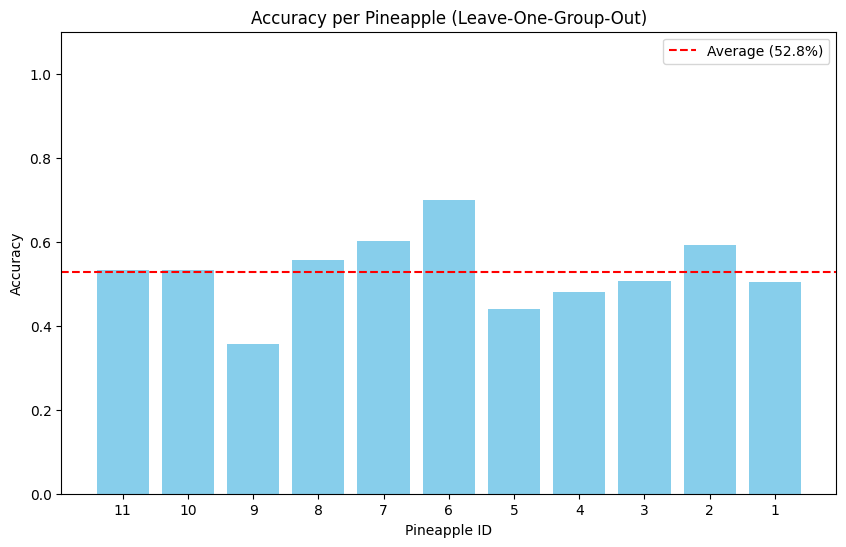

💡 解讀指南：
1. 如果這裡的平均準確率還有 > 85%，那你的模型就是世界級的！
2. 如果掉到 50-60%，代表個體差異很大，需要用更強的模型 (如 LSTM)。


In [13]:
# ===== Cell 13: 終極驗證 (Leave-One-Group-Out Cross Validation) =====

import numpy as np
import pandas as pd
from sklearn.model_selection import LeaveOneGroupOut
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
import os

# 1. 準備數據
# 我們需要 'groups' 也就是 pineapple_id，這在 feature_matrix.csv 沒存
# 但我們可以用 meta_data.csv 找回來

print("🚀 開始終極驗證 (Leave-One-Group-Out)...")
print("="*60)

# 載入數據
X = pd.read_csv('data/processed/feature_matrix.csv')
y = np.load('data/processed/labels.npy')
meta = pd.read_csv('data/processed/meta_data.csv')

groups = meta['pid'] # 這就是我們的分組依據 (鳳梨編號)

print(f"總樣本數: {len(X)}")
print(f"鳳梨總數: {len(groups.unique())}")
print(f"鳳梨 ID列表: {groups.unique()}")

# 2. 設定驗證器
logo = LeaveOneGroupOut()
accuracies = []

print("\n開始交叉驗證 (這可能會花一點時間)...")

# 3. 迴圈驗證 (輪流當測試集)
for train_idx, test_idx in logo.split(X, y, groups=groups):
    # 取得當前測試的鳳梨 ID
    test_pid = groups.iloc[test_idx[0]]
    
    # 切分數據
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]
    
    # 訓練模型
    clf = RandomForestClassifier(n_estimators=50, random_state=42, n_jobs=-1)
    clf.fit(X_train, y_train)
    
    # 預測
    y_pred = clf.predict(X_test)
    
    # 計算準確率
    acc = accuracy_score(y_test, y_pred)
    accuracies.append(acc)
    
    print(f"   🍍 Testing on Pineapple {test_pid}: Accuracy = {acc:.4f} ({acc*100:.1f}%)")

# 4. 總結報告
mean_acc = np.mean(accuracies)
print("\n" + "="*60)
print(f"🏆 真實平均準確率: {mean_acc:.4f} ({mean_acc*100:.2f}%)")
print("="*60)

# 畫圖
plt.figure(figsize=(10, 6))
plt.bar(groups.unique().astype(str), accuracies, color='skyblue')
plt.axhline(mean_acc, color='red', linestyle='--', label=f'Average ({mean_acc*100:.1f}%)')
plt.title('Accuracy per Pineapple (Leave-One-Group-Out)')
plt.xlabel('Pineapple ID')
plt.ylabel('Accuracy')
plt.legend()
plt.ylim(0, 1.1)
plt.show()

print("💡 解讀指南：")
print("1. 如果這裡的平均準確率還有 > 85%，那你的模型就是世界級的！")
print("2. 如果掉到 50-60%，代表個體差異很大，需要用更強的模型 (如 LSTM)。")

In [14]:
!pip install tensorflow


[notice] A new release of pip is available: 24.2 -> 26.0.1
[notice] To update, run: python -m pip install --upgrade pip


🚀 啟動 SVM 輕量級訓練 (Group Scaling)...
⚖️ 正在執行群組標準化 (消除個體差異)...
✅ 數據標準化完成！

開始 11 輪交叉驗證 (SVM 速度很快)...
  鳳梨 ID    |    準確率 (Accuracy)   
------------------------------------------------------------
      1     |              27.68%
      2     |              50.82%
      3     |              38.24%
      4     |              44.88%
      5     |              50.59%
      6     |              38.71%
      7     |              71.72%
      8     |              61.12%
      9     |              28.98%
      10    |              55.98%
      11    |              39.24%
🏆 最終平均準確率: 0.4618 (46.18%)


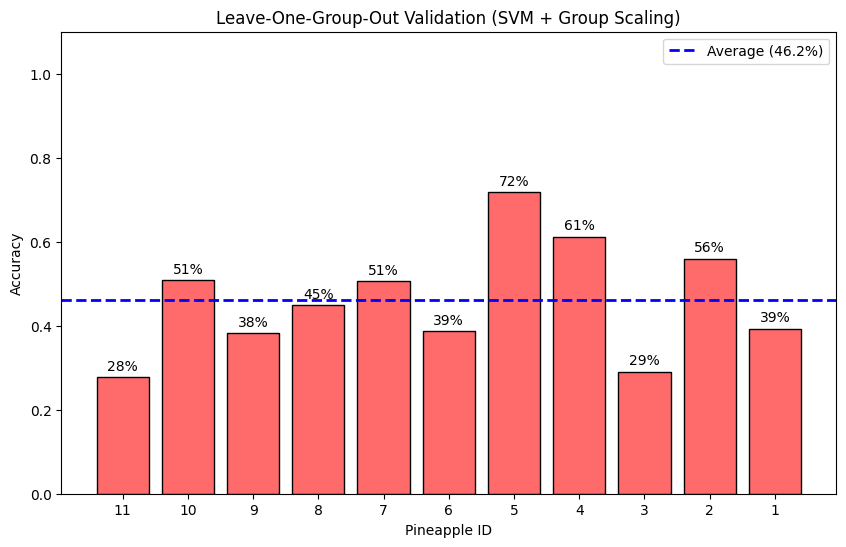

In [15]:
# ===== Cell 14: 輕量級替代方案 - SVM + 群組標準化 (Group Scaling) =====

import numpy as np
import pandas as pd
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import LeaveOneGroupOut
from sklearn.metrics import accuracy_score
from sklearn.pipeline import make_pipeline
import matplotlib.pyplot as plt
import seaborn as sns

# 1. 準備數據
print("🚀 啟動 SVM 輕量級訓練 (Group Scaling)...")
X_raw = pd.read_csv('data/processed/feature_matrix.csv')
y_raw = np.load('data/processed/labels.npy')
meta = pd.read_csv('data/processed/meta_data.csv')
groups = meta['pid']

# 2. 關鍵步驟：群組標準化 (Group Standardization)
# 我們手動對每一顆鳳梨做標準化，而不是全體一起做
print("⚖️ 正在執行群組標準化 (消除個體差異)...")

X_scaled = X_raw.copy()
# 針對每個 sensor 的每個 feature 做處理
features = X_raw.columns

for pid in groups.unique():
    mask = (groups == pid)
    # 取出這顆鳳梨的數據
    subset = X_raw.loc[mask, features]
    
    # 標準化：(x - mean) / std
    # 這樣每顆鳳梨的數值分布都會變成以 0 為中心，變異數為 1
    subset_scaled = (subset - subset.mean()) / (subset.std() + 1e-8) # 加一點點防呆避免除以0
    
    # 填回
    X_scaled.loc[mask, features] = subset_scaled

# 填補可能的 NaN
X_scaled = X_scaled.fillna(0)

print("✅ 數據標準化完成！")

# 3. 設定 SVM 模型
# C=1.0: 預設值
# kernel='rbf': 適合非線性分類 (氣味變化通常是非線性的)
# class_weight='balanced': 自動調整權重，避免某些 Stage 樣本太多
clf = SVC(kernel='rbf', C=1.0, class_weight='balanced', random_state=42)

# 4. 開始 LOGO 驗證
logo = LeaveOneGroupOut()
accuracies = []
unique_pids = groups.unique()

print(f"\n開始 11 輪交叉驗證 (SVM 速度很快)...")
print(f"{'='*60}")
print(f"{'鳳梨 ID':^10} | {'準確率 (Accuracy)':^20}")
print(f"{'-'*60}")

for train_idx, test_idx in logo.split(X_scaled, y_raw, groups=groups):
    test_pid = groups.iloc[test_idx[0]]
    
    X_train, X_test = X_scaled.iloc[train_idx], X_scaled.iloc[test_idx]
    y_train, y_test = y_raw[train_idx], y_raw[test_idx]
    
    # 訓練
    clf.fit(X_train, y_train)
    
    # 預測
    y_pred = clf.predict(X_test)
    
    # 評估
    acc = accuracy_score(y_test, y_pred)
    accuracies.append(acc)
    
    print(f"   {test_pid:^8} | {acc*100:18.2f}%")

# 5. 總結
mean_acc = np.mean(accuracies)
print(f"{'='*60}")
print(f"🏆 最終平均準確率: {mean_acc:.4f} ({mean_acc*100:.2f}%)")
print(f"{'='*60}")

# 畫圖
plt.figure(figsize=(10, 6))
bars = plt.bar(unique_pids.astype(str), accuracies, color='#FF6B6B', edgecolor='black')
plt.axhline(mean_acc, color='blue', linestyle='--', linewidth=2, label=f'Average ({mean_acc*100:.1f}%)')

for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + 0.01,
             f'{height*100:.0f}%', ha='center', va='bottom')

plt.title('Leave-One-Group-Out Validation (SVM + Group Scaling)')
plt.xlabel('Pineapple ID')
plt.ylabel('Accuracy')
plt.ylim(0, 1.1)
plt.legend()
plt.show()

🚀 開始終極驗證 (SVM + Leave-One-Group-Out) [強化版] ...
總樣本數: 97196
鳳梨總數: 11
鳳梨 ID 列表: [np.int64(11), np.int64(10), np.int64(9), np.int64(8), np.int64(7), np.int64(6), np.int64(5), np.int64(4), np.int64(3), np.int64(2), np.int64(1)]

🧪 實驗：4class_BASE
   use_per_pid_norm = False
  🍍 Test 1: acc=70.10% | n=9000
  🍍 Test 2: acc=50.93% | n=12600
  🍍 Test 3: acc=15.12% | n=9900
  🍍 Test 4: acc=45.69% | n=9900
  🍍 Test 5: acc=62.53% | n=9000
  🍍 Test 6: acc=57.78% | n=8098
  🍍 Test 7: acc=59.47% | n=9898
  🍍 Test 8: acc=66.97% | n=9900
  🍍 Test 9: acc=38.83% | n=8100
  🍍 Test 10: acc=54.57% | n=5400
  🍍 Test 11: acc=44.76% | n=5400

📌 Overall:
  平均 accuracy = 51.52%
  最低 accuracy = 15.12%
  最高 accuracy = 70.10%

📄 Classification report (overall):
              precision    recall  f1-score   support

           0     0.7085    0.6290    0.6664     28129
           1     0.4266    0.4869    0.4547     22716
           2     0.5455    0.3967    0.4594     29926
           3     0.3853    0.5753    0.46

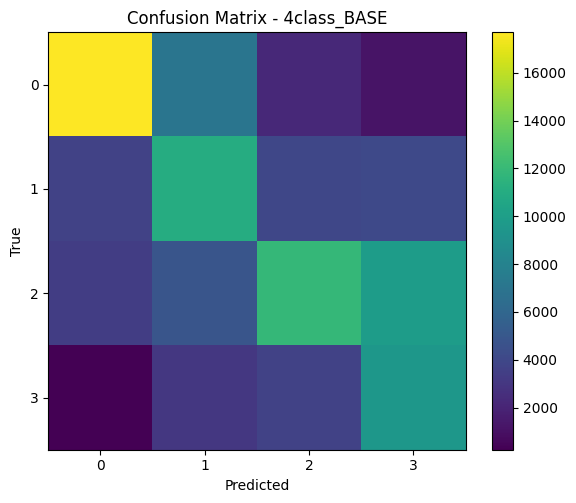


🧪 實驗：4class_PER_PID_NORM
   use_per_pid_norm = True
  🍍 Test 1: acc=26.50% | n=9000
  🍍 Test 2: acc=46.45% | n=12600
  🍍 Test 3: acc=39.33% | n=9900
  🍍 Test 4: acc=41.65% | n=9900
  🍍 Test 5: acc=44.28% | n=9000
  🍍 Test 6: acc=35.87% | n=8098
  🍍 Test 7: acc=72.29% | n=9898
  🍍 Test 8: acc=59.83% | n=9900
  🍍 Test 9: acc=31.59% | n=8100
  🍍 Test 10: acc=55.65% | n=5400
  🍍 Test 11: acc=33.65% | n=5400

📌 Overall:
  平均 accuracy = 44.28%
  最低 accuracy = 26.50%
  最高 accuracy = 72.29%

📄 Classification report (overall):
              precision    recall  f1-score   support

           0     0.5842    0.6959    0.6352     28129
           1     0.3903    0.3772    0.3836     22716
           2     0.4120    0.3631    0.3860     29926
           3     0.2991    0.2796    0.2890     16425

    accuracy                         0.4486     97196
   macro avg     0.4214    0.4290    0.4235     97196
weighted avg     0.4377    0.4486    0.4412     97196

🧾 Confusion matrix (overall):
[[19576  3

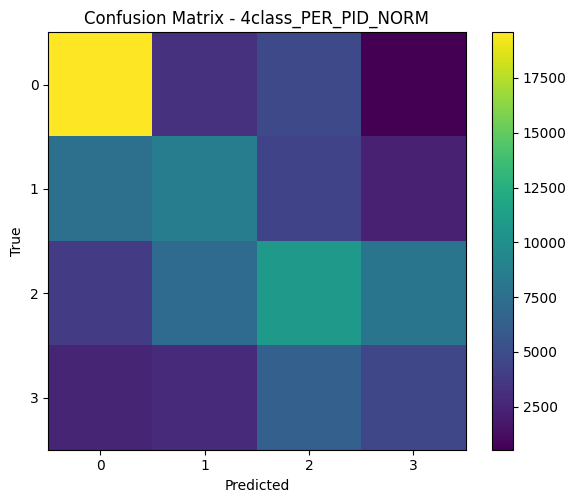


🧪 實驗：BINARY_BASE
   use_per_pid_norm = False
  🍍 Test 1: acc=62.04% | n=9000
  🍍 Test 2: acc=64.25% | n=12600
  🍍 Test 3: acc=85.81% | n=9900
  🍍 Test 4: acc=78.40% | n=9900
  🍍 Test 5: acc=59.63% | n=9000
  🍍 Test 6: acc=77.76% | n=8098
  🍍 Test 7: acc=97.30% | n=9898
  🍍 Test 8: acc=99.60% | n=9900
  🍍 Test 9: acc=60.41% | n=8100
  🍍 Test 10: acc=78.85% | n=5400
  🍍 Test 11: acc=70.74% | n=5400

📌 Overall:
  平均 accuracy = 75.89%
  最低 accuracy = 59.63%
  最高 accuracy = 99.60%

📄 Classification report (overall):
              precision    recall  f1-score   support

           0     0.7797    0.7597    0.7695     50845
           1     0.7436    0.7645    0.7539     46351

    accuracy                         0.7620     97196
   macro avg     0.7616    0.7621    0.7617     97196
weighted avg     0.7625    0.7620    0.7621     97196

🧾 Confusion matrix (overall):
[[38626 12219]
 [10915 35436]]


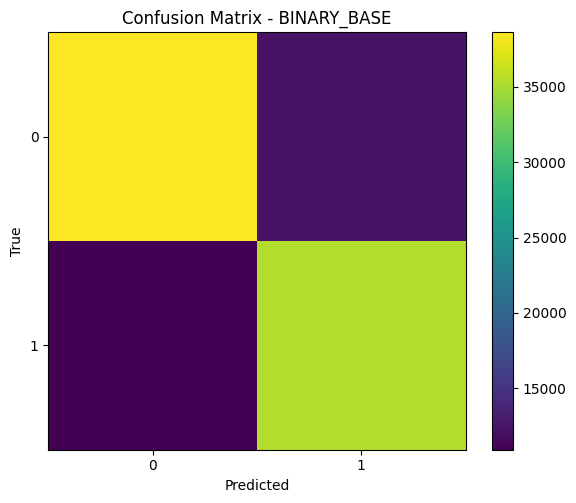


🧪 實驗：BINARY_PER_PID_NORM
   use_per_pid_norm = True
  🍍 Test 1: acc=37.52% | n=9000
  🍍 Test 2: acc=77.81% | n=12600
  🍍 Test 3: acc=83.34% | n=9900
  🍍 Test 4: acc=80.64% | n=9900
  🍍 Test 5: acc=70.78% | n=9000
  🍍 Test 6: acc=86.75% | n=8098
  🍍 Test 7: acc=73.79% | n=9898
  🍍 Test 8: acc=76.74% | n=9900
  🍍 Test 9: acc=55.56% | n=8100
  🍍 Test 10: acc=89.67% | n=5400
  🍍 Test 11: acc=34.83% | n=5400

📌 Overall:
  平均 accuracy = 69.77%
  最低 accuracy = 34.83%
  最高 accuracy = 89.67%

📄 Classification report (overall):
              precision    recall  f1-score   support

           0     0.7139    0.7412    0.7273     50845
           1     0.7037    0.6741    0.6886     46351

    accuracy                         0.7092     97196
   macro avg     0.7088    0.7077    0.7079     97196
weighted avg     0.7090    0.7092    0.7088     97196

🧾 Confusion matrix (overall):
[[37687 13158]
 [15104 31247]]


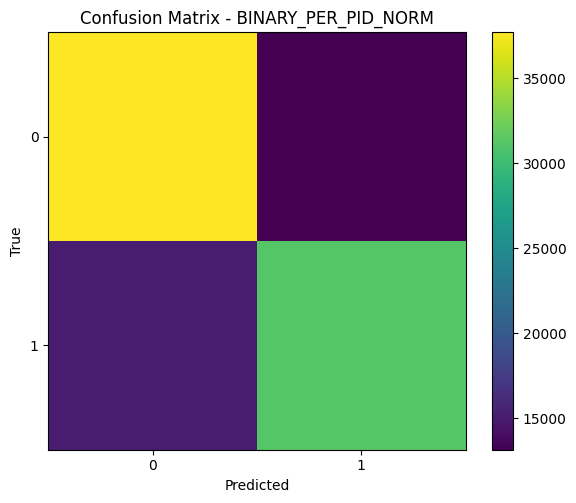


✅ 結果總結（平均 accuracy）
4-class BASE              : 51.52%
4-class PER_PID_NORM      : 44.28%
Binary  BASE              : 75.89%
Binary  PER_PID_NORM      : 69.77%

🔎 建議你特別看：Pineapple 3/4 在 PER_PID_NORM 和 Binary 是否有明顯拉升。


In [16]:
# ===== Cell 14: 終極驗證 (SVM + Leave-One-Group-Out Cross Validation) - 強化版 =====
# ✅ 加強項目：
# 1) class_weight='balanced'：處理 stage 不平衡（很常見）
# 2) per-pineapple normalization（每顆鳳梨內 z-score）：減少個體差異干擾（方向 B）
# 3) 同步做二分類 Early vs Late：檢驗實務可用性（方向 A）
# 4) 兩套結果都印 per-pid accuracy + overall 平均 + confusion matrix

import numpy as np
import pandas as pd
from sklearn.model_selection import LeaveOneGroupOut
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import os

print("🚀 開始終極驗證 (SVM + Leave-One-Group-Out) [強化版] ...")
print("="*70)

# =========================
# 1) 載入 Step 4 產生的特徵與標籤
# =========================
X = pd.read_csv('data/processed/feature_matrix.csv')
y = np.load('data/processed/labels.npy')
meta = pd.read_csv('data/processed/meta_data.csv')
groups = meta['pid']  # 每個樣本對應的鳳梨 ID

print(f"總樣本數: {len(X)}")
print(f"鳳梨總數: {len(groups.unique())}")
print(f"鳳梨 ID 列表: {list(groups.unique())}")

# 建立輸出資料夾
eval_dir = 'reports/figures/model_evaluation'
os.makedirs(eval_dir, exist_ok=True)

logo = LeaveOneGroupOut()

# =========================
# 工具：per-pineapple normalization（方向 B）
# =========================
def per_group_zscore(X_df: pd.DataFrame, g: pd.Series, eps: float = 1e-6) -> pd.DataFrame:
    """
    對每個 group（pid）各自做 z-score：
      X_g = (X - mean_g) / (std_g + eps)
    ✅ 注意：這不使用任何 label，只是把「同一顆鳳梨內」的相對變化凸顯出來
    """
    Xn = X_df.copy()
    for pid in pd.unique(g):
        mask = (g == pid)
        X_pid = X_df.loc[mask]
        mu = X_pid.mean(axis=0)
        sd = X_pid.std(axis=0).replace(0, np.nan)
        Xn.loc[mask] = (X_pid - mu) / (sd.fillna(eps) + eps)
    return Xn

# =========================
# 工具：跑一次 LOGO（可選擇是否使用 per-pineapple normalization）
# =========================
def run_logo_experiment(X_in: pd.DataFrame, y_in: np.ndarray, groups_in: pd.Series,
                        use_per_pid_norm: bool,
                        title: str):
    print("\n" + "="*70)
    print(f"🧪 實驗：{title}")
    print(f"   use_per_pid_norm = {use_per_pid_norm}")
    print("="*70)

    accuracies = []
    test_pids = []
    y_true_all = []
    y_pred_all = []

    for train_idx, test_idx in logo.split(X_in, y_in, groups=groups_in):
        test_pid = groups_in.iloc[test_idx[0]]
        test_pids.append(test_pid)

        X_train, X_test = X_in.iloc[train_idx], X_in.iloc[test_idx]
        y_train, y_test = y_in[train_idx], y_in[test_idx]

        g_train = groups_in.iloc[train_idx]
        g_test  = groups_in.iloc[test_idx]

        # ✅ 方向 B：每顆鳳梨內標準化（train 的每顆鳳梨用自己統計；test 鳳梨也用自己統計）
        if use_per_pid_norm:
            X_train = per_group_zscore(X_train, g_train)
            X_test  = per_group_zscore(X_test,  g_test)

        # 仍保留「fold 內 StandardScaler」：SVM 尺度敏感（fit on train, transform test）
        scaler = StandardScaler()
        X_train_s = scaler.fit_transform(X_train)
        X_test_s  = scaler.transform(X_test)

        # ✅ SVM：加 class_weight balanced（通常會讓 LOGO 更穩）
        clf = SVC(
            kernel='rbf',
            C=3.0,               # 比原本 1.0 稍微強一點（常見會更穩）
            gamma='scale',
            class_weight='balanced',
            probability=False,
            random_state=42
        )
        clf.fit(X_train_s, y_train)
        y_pred = clf.predict(X_test_s)

        acc = accuracy_score(y_test, y_pred)
        accuracies.append(acc)

        y_true_all.append(y_test)
        y_pred_all.append(y_pred)

        print(f"  🍍 Test {test_pid}: acc={acc*100:.2f}% | n={len(y_test)}")

    # overall
    y_true_all = np.concatenate(y_true_all)
    y_pred_all = np.concatenate(y_pred_all)

    print("\n📌 Overall:")
    print(f"  平均 accuracy = {np.mean(accuracies)*100:.2f}%")
    print(f"  最低 accuracy = {np.min(accuracies)*100:.2f}%")
    print(f"  最高 accuracy = {np.max(accuracies)*100:.2f}%")

    print("\n📄 Classification report (overall):")
    print(classification_report(y_true_all, y_pred_all, digits=4))

    cm = confusion_matrix(y_true_all, y_pred_all)
    print("🧾 Confusion matrix (overall):")
    print(cm)

    # 畫 confusion matrix（不用 seaborn，避免環境差異）
    plt.figure(figsize=(6, 5))
    plt.imshow(cm, interpolation='nearest')
    plt.title(f'Confusion Matrix - {title}')
    plt.colorbar()
    tick_marks = np.arange(len(np.unique(y_in)))
    plt.xticks(tick_marks, tick_marks)
    plt.yticks(tick_marks, tick_marks)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.tight_layout()

    out_png = os.path.join(eval_dir, f'cm_{title.replace(" ", "_").replace("/", "_")}.png')
    plt.savefig(out_png, dpi=150)
    plt.show()

    return {
        "title": title,
        "mean_acc": float(np.mean(accuracies)),
        "per_pid": dict(zip(test_pids, accuracies)),
        "cm": cm
    }

# =========================
# 2) 4-class：原版 vs per-pineapple norm（方向 B）
# =========================
res_4cls_base = run_logo_experiment(
    X_in=X, y_in=y, groups_in=groups,
    use_per_pid_norm=False,
    title="4class_BASE"
)

res_4cls_ppn = run_logo_experiment(
    X_in=X, y_in=y, groups_in=groups,
    use_per_pid_norm=True,
    title="4class_PER_PID_NORM"
)

# =========================
# 3) 二分類：Early vs Late（方向 A）
#   - Stage 0/1 => 0（早期）
#   - Stage 2/3 => 1（晚期）
# =========================
y_binary = (y >= 2).astype(int)

res_bin_base = run_logo_experiment(
    X_in=X, y_in=y_binary, groups_in=groups,
    use_per_pid_norm=False,
    title="BINARY_BASE"
)

res_bin_ppn = run_logo_experiment(
    X_in=X, y_in=y_binary, groups_in=groups,
    use_per_pid_norm=True,
    title="BINARY_PER_PID_NORM"
)

print("\n" + "="*70)
print("✅ 結果總結（平均 accuracy）")
print("="*70)
print(f"4-class BASE              : {res_4cls_base['mean_acc']*100:.2f}%")
print(f"4-class PER_PID_NORM      : {res_4cls_ppn['mean_acc']*100:.2f}%")
print(f"Binary  BASE              : {res_bin_base['mean_acc']*100:.2f}%")
print(f"Binary  PER_PID_NORM      : {res_bin_ppn['mean_acc']*100:.2f}%")

print("\n🔎 建議你特別看：Pineapple 3/4 在 PER_PID_NORM 和 Binary 是否有明顯拉升。")


In [17]:
# ===== 新增 Cell：Global Threshold Labeling（跨鳳梨一致）+ LOGO 4-class 評估 =====
import numpy as np
import pandas as pd
from sklearn.model_selection import LeaveOneGroupOut
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

print("="*70)
print("🚀 Global Threshold Labeling (proxy→smooth→monotonic→GLOBAL quantiles) + LOGO Eval")
print("="*70)

# 讀資料
X = pd.read_csv('data/processed/feature_matrix.csv')
meta = pd.read_csv('data/processed/meta_data.csv')
groups = meta['pid'].astype(int).values

# --- 自動找欄位（避免你欄名略有不同） ---
def find_col(cands):
    for c in cands:
        if c in X.columns:
            return c
    # 模糊找
    for c in X.columns:
        for key in cands:
            if key.lower() in c.lower():
                return c
    return None

mq135_col = find_col(["MQ135_Rs_R0", "mq135_rs_r0", "MQ135"])
tgs2602_col = find_col(["TGS2602_Rs_R0", "tgs2602_rs_r0", "TGS2602"])

if mq135_col is None or tgs2602_col is None:
    raise ValueError(f"找不到 proxy 欄位：mq135_col={mq135_col}, tgs2602_col={tgs2602_col}. "
                     f"請檢查 feature_matrix.csv 欄名。")

print(f"✅ 使用 proxy 欄位：MQ135={mq135_col}, TGS2602={tgs2602_col}")

# --- 建 proxy ---
proxy_raw = 0.4 * X[mq135_col].values.astype(float) + 0.6 * X[tgs2602_col].values.astype(float)

# --- 平滑（不用 scipy，手寫簡單移動平均） ---
def moving_average(x, w=31):
    w = int(w)
    if w <= 1:
        return x.copy()
    if w % 2 == 0:
        w += 1
    k = np.ones(w, dtype=float) / w
    return np.convolve(x, k, mode='same')

# --- 每顆鳳梨：平滑 + 單調 ---
SMOOTH_W = 31
proxy_mono = proxy_raw.copy()

for pid in np.unique(groups):
    idx = np.where(groups == pid)[0]
    p = proxy_raw[idx]
    p_s = moving_average(p, SMOOTH_W)
    p_m = np.maximum.accumulate(p_s)  # 單調不倒退
    proxy_mono[idx] = p_m

# --- 用全體 proxy_mono 的 global quantiles 當切點 ---
q1, q2, q3 = np.quantile(proxy_mono, [0.25, 0.50, 0.75])
print(f"📌 Global cutpoints: Q25={q1:.6f}, Q50={q2:.6f}, Q75={q3:.6f}")

# --- 產生 4-class labels（跨鳳梨一致） ---
y_global = np.zeros(len(proxy_mono), dtype=int)
y_global[proxy_mono >= q1] = 1
y_global[proxy_mono >= q2] = 2
y_global[proxy_mono >= q3] = 3

# 存檔
out_path = "data/processed/labels_global.npy"
np.save(out_path, y_global)
print(f"✅ 已輸出：{out_path}")

# --- LOGO 評估（跟你 baseline 同設定） ---
logo = LeaveOneGroupOut()
accs = []
y_true_all = []
y_pred_all = []

for train_idx, test_idx in logo.split(X, y_global, groups=groups):
    test_pid = groups[test_idx[0]]

    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y_global[train_idx], y_global[test_idx]

    scaler = StandardScaler()
    X_train_s = scaler.fit_transform(X_train)
    X_test_s  = scaler.transform(X_test)

    clf = SVC(
        kernel='rbf',
        C=3.0,
        gamma='scale',
        class_weight='balanced',
        random_state=42
    )
    clf.fit(X_train_s, y_train)
    y_pred = clf.predict(X_test_s)

    acc = accuracy_score(y_test, y_pred)
    accs.append(acc)

    y_true_all.append(y_test)
    y_pred_all.append(y_pred)

    print(f"🍍 Test {test_pid}: acc={acc*100:.2f}% | n={len(y_test)}")

y_true_all = np.concatenate(y_true_all)
y_pred_all = np.concatenate(y_pred_all)

print("\n" + "="*70)
print("📊 Overall Result (GLOBAL labels)")
print("="*70)
print(f"平均 accuracy: {np.mean(accs)*100:.2f}%")
print(f"最低 accuracy: {np.min(accs)*100:.2f}%")
print(f"最高 accuracy: {np.max(accs)*100:.2f}%")

print("\n🧾 Confusion Matrix:")
print(confusion_matrix(y_true_all, y_pred_all))

within_1 = float(np.mean(np.abs(y_true_all - y_pred_all) <= 1))
print(f"\n✅ ±1 Accuracy（差一階也算合理）: {within_1*100:.2f}%")
print("\n📄 Classification report:")
print(classification_report(y_true_all, y_pred_all, digits=4))


🚀 Global Threshold Labeling (proxy→smooth→monotonic→GLOBAL quantiles) + LOGO Eval
✅ 使用 proxy 欄位：MQ135=MQ135_Rs_R0, TGS2602=TGS2602_Rs_R0
📌 Global cutpoints: Q25=25.225091, Q50=52.481343, Q75=79.945361
✅ 已輸出：data/processed/labels_global.npy
🍍 Test 1: acc=55.46% | n=9000
🍍 Test 2: acc=71.39% | n=12600
🍍 Test 3: acc=90.48% | n=9900
🍍 Test 4: acc=75.09% | n=9900
🍍 Test 5: acc=92.71% | n=9000
🍍 Test 6: acc=90.73% | n=8098
🍍 Test 7: acc=83.67% | n=9898
🍍 Test 8: acc=70.79% | n=9900
🍍 Test 9: acc=96.53% | n=8100
🍍 Test 10: acc=50.20% | n=5400
🍍 Test 11: acc=41.22% | n=5400

📊 Overall Result (GLOBAL labels)
平均 accuracy: 74.39%
最低 accuracy: 41.22%
最高 accuracy: 96.53%

🧾 Confusion Matrix:
[[17260  3437     0    94]
 [ 7353 13086  1645   136]
 [    1  1689 15711  4602]
 [    0     0  4124 28058]]

✅ ±1 Accuracy（差一階也算合理）: 99.76%

📄 Classification report:
              precision    recall  f1-score   support

           0     0.7012    0.8302    0.7603     20791
           1     0.7185    0.5889   

In [18]:
# ===== 新增 Cell：Random Forest + GLOBAL labels (LOGO) =====
import numpy as np
import pandas as pd
from sklearn.model_selection import LeaveOneGroupOut
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix

print("="*70)
print("🌲 Random Forest + GLOBAL labels (LOGO)")
print("="*70)

X = pd.read_csv('data/processed/feature_matrix.csv')
y_global = np.load('data/processed/labels_global.npy')
meta = pd.read_csv('data/processed/meta_data.csv')
groups = meta['pid'].astype(int).values

logo = LeaveOneGroupOut()
accs = []

for train_idx, test_idx in logo.split(X, y_global, groups=groups):
    test_pid = groups[test_idx[0]]

    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y_global[train_idx], y_global[test_idx]

    clf = RandomForestClassifier(
        n_estimators=300,
        max_depth=None,
        min_samples_split=5,
        min_samples_leaf=3,
        random_state=42,
        n_jobs=-1
    )

    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)

    acc = accuracy_score(y_test, y_pred)
    accs.append(acc)

    print(f"🍍 Test {test_pid}: acc={acc*100:.2f}% | n={len(y_test)}")

print("\n📊 Overall Result (RF + GLOBAL labels)")
print("="*70)
print(f"平均 accuracy: {np.mean(accs)*100:.2f}%")
print(f"最低 accuracy: {np.min(accs)*100:.2f}%")
print(f"最高 accuracy: {np.max(accs)*100:.2f}%")


🌲 Random Forest + GLOBAL labels (LOGO)
🍍 Test 1: acc=66.68% | n=9000
🍍 Test 2: acc=71.37% | n=12600
🍍 Test 3: acc=85.24% | n=9900
🍍 Test 4: acc=66.06% | n=9900
🍍 Test 5: acc=93.61% | n=9000
🍍 Test 6: acc=98.43% | n=8098
🍍 Test 7: acc=91.09% | n=9898
🍍 Test 8: acc=90.65% | n=9900
🍍 Test 9: acc=98.10% | n=8100
🍍 Test 10: acc=34.93% | n=5400
🍍 Test 11: acc=79.80% | n=5400

📊 Overall Result (RF + GLOBAL labels)
平均 accuracy: 79.63%
最低 accuracy: 34.93%
最高 accuracy: 98.43%


In [19]:
# ===== 新增 Cell：XGBoost + GLOBAL labels (LOGO) =====
import numpy as np
import pandas as pd
from sklearn.model_selection import LeaveOneGroupOut
from sklearn.metrics import accuracy_score
from xgboost import XGBClassifier

print("="*70)
print("🚀 XGBoost + GLOBAL labels (LOGO)")
print("="*70)

X = pd.read_csv('data/processed/feature_matrix.csv')
y_global = np.load('data/processed/labels_global.npy')
meta = pd.read_csv('data/processed/meta_data.csv')
groups = meta['pid'].astype(int).values

logo = LeaveOneGroupOut()
accs = []
per_pid = {}

for train_idx, test_idx in logo.split(X, y_global, groups=groups):
    pid = int(groups[test_idx[0]])

    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y_global[train_idx], y_global[test_idx]

    clf = XGBClassifier(
        n_estimators=600,
        max_depth=6,
        learning_rate=0.05,
        subsample=0.8,
        colsample_bytree=0.8,
        objective='multi:softmax',
        num_class=4,
        eval_metric='mlogloss',
        random_state=42,
        n_jobs=-1
    )

    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)

    acc = accuracy_score(y_test, y_pred)
    accs.append(acc)
    per_pid[pid] = acc

    print(f"🍍 Test {pid}: acc={acc*100:.2f}% | n={len(y_test)}")

print("\n📊 Overall:")
print(f"平均 accuracy: {np.mean(accs)*100:.2f}%")
print(f"最低 accuracy: {np.min(accs)*100:.2f}%")
print(f"最高 accuracy: {np.max(accs)*100:.2f}%")
print(f"Pineapple 10 acc: {per_pid.get(10,0)*100:.2f}%")


🚀 XGBoost + GLOBAL labels (LOGO)
🍍 Test 1: acc=65.54% | n=9000
🍍 Test 2: acc=64.24% | n=12600
🍍 Test 3: acc=86.89% | n=9900
🍍 Test 4: acc=69.15% | n=9900
🍍 Test 5: acc=93.10% | n=9000
🍍 Test 6: acc=98.43% | n=8098
🍍 Test 7: acc=93.68% | n=9898
🍍 Test 8: acc=84.42% | n=9900
🍍 Test 9: acc=98.10% | n=8100
🍍 Test 10: acc=22.20% | n=5400
🍍 Test 11: acc=93.09% | n=5400

📊 Overall:
平均 accuracy: 78.99%
最低 accuracy: 22.20%
最高 accuracy: 98.43%
Pineapple 10 acc: 22.20%


In [20]:
# ===== 新增 Cell：LightGBM + GLOBAL labels (LOGO) [Fixed Stratified Valid Split] =====
import numpy as np
import pandas as pd
from sklearn.model_selection import LeaveOneGroupOut, StratifiedShuffleSplit
from sklearn.metrics import accuracy_score

print("="*70)
print("🚀 LightGBM + GLOBAL labels (LOGO) [Fixed]")
print("="*70)

# 1) 確認 lightgbm 可用
try:
    import lightgbm as lgb
except Exception:
    import sys
    print("⚠️ 未偵測到 lightgbm，嘗試安裝中...")
    !{sys.executable} -m pip install -q lightgbm
    import lightgbm as lgb

# 2) 讀資料
X = pd.read_csv('data/processed/feature_matrix.csv')
y_global = np.load('data/processed/labels_global.npy')
meta = pd.read_csv('data/processed/meta_data.csv')
groups = meta['pid'].astype(int).values

logo = LeaveOneGroupOut()
accs = []
per_pid = {}

# 3) LightGBM 參數（偏穩定、避免分裂失敗）
LGB_PARAMS = dict(
    objective="multiclass",
    num_class=4,
    learning_rate=0.05,
    n_estimators=4000,          # 搭配 early stopping
    num_leaves=63,
    min_child_samples=10,       # 降低一點，避免「分不下去」
    subsample=0.8,
    subsample_freq=1,
    colsample_bytree=0.8,
    reg_alpha=0.0,
    reg_lambda=1.0,
    random_state=42,
    n_jobs=-1,
    force_row_wise=True,        # 讓 log 少一點、也更穩
    verbose=-1
)

for train_idx, test_idx in logo.split(X, y_global, groups=groups):
    pid = int(groups[test_idx[0]])

    X_train = X.iloc[train_idx]
    y_train = y_global[train_idx]
    X_test  = X.iloc[test_idx]
    y_test  = y_global[test_idx]

    # ✅ 重點：在 train 裡用分層抽樣切 valid（確保四類都有）
    sss = StratifiedShuffleSplit(n_splits=1, test_size=0.1, random_state=42)
    tr_sub_idx, va_sub_idx = next(sss.split(X_train, y_train))

    X_tr = X_train.iloc[tr_sub_idx]
    y_tr = y_train[tr_sub_idx]
    X_va = X_train.iloc[va_sub_idx]
    y_va = y_train[va_sub_idx]

    clf = lgb.LGBMClassifier(**LGB_PARAMS)
    clf.fit(
        X_tr, y_tr,
        eval_set=[(X_va, y_va)],
        eval_metric="multi_logloss",
        callbacks=[lgb.early_stopping(stopping_rounds=80, verbose=False)]
    )

    y_pred = clf.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    accs.append(acc)
    per_pid[pid] = acc

    print(f"🍍 Test {pid}: acc={acc*100:.2f}% | n={len(y_test)} | best_iter={clf.best_iteration_}")

print("\n📊 Overall:")
print(f"平均 accuracy: {np.mean(accs)*100:.2f}%")
print(f"最低 accuracy: {np.min(accs)*100:.2f}%")
print(f"最高 accuracy: {np.max(accs)*100:.2f}%")
print(f"Pineapple 10 acc: {per_pid.get(10,0)*100:.2f}%")


🚀 LightGBM + GLOBAL labels (LOGO) [Fixed]
🍍 Test 1: acc=70.71% | n=9000 | best_iter=173
🍍 Test 2: acc=71.37% | n=12600 | best_iter=173
🍍 Test 3: acc=83.98% | n=9900 | best_iter=175
🍍 Test 4: acc=70.68% | n=9900 | best_iter=177
🍍 Test 5: acc=93.48% | n=9000 | best_iter=159
🍍 Test 6: acc=98.43% | n=8098 | best_iter=150
🍍 Test 7: acc=93.46% | n=9898 | best_iter=209
🍍 Test 8: acc=78.57% | n=9900 | best_iter=151
🍍 Test 9: acc=98.10% | n=8100 | best_iter=122
🍍 Test 10: acc=21.63% | n=5400 | best_iter=162
🍍 Test 11: acc=92.50% | n=5400 | best_iter=149

📊 Overall:
平均 accuracy: 79.36%
最低 accuracy: 21.63%
最高 accuracy: 98.43%
Pineapple 10 acc: 21.63%


In [21]:
# ===== 新增 Cell：Soft Voting Ensemble (XGBoost + LightGBM) + GLOBAL labels (LOGO) =====
import numpy as np
import pandas as pd
from sklearn.model_selection import LeaveOneGroupOut, StratifiedShuffleSplit
from sklearn.metrics import accuracy_score

print("="*70)
print("🗳️ Soft Voting Ensemble (XGBoost + LightGBM) + GLOBAL labels (LOGO)")
print("="*70)

# --- 讀資料 ---
X = pd.read_csv('data/processed/feature_matrix.csv')
y = np.load('data/processed/labels_global.npy')
meta = pd.read_csv('data/processed/meta_data.csv')
groups = meta['pid'].astype(int).values

# --- 依序載入套件 ---
from xgboost import XGBClassifier
import lightgbm as lgb

logo = LeaveOneGroupOut()
accs = []
per_pid = {}

# 你可以調權重（先用 0.5/0.5）
W_XGB = 0.5
W_LGB = 0.5

for train_idx, test_idx in logo.split(X, y, groups=groups):
    pid = int(groups[test_idx[0]])

    X_train = X.iloc[train_idx]
    y_train = y[train_idx]
    X_test  = X.iloc[test_idx]
    y_test  = y[test_idx]

    # --- LightGBM 需要 stratified valid 做 early stopping ---
    sss = StratifiedShuffleSplit(n_splits=1, test_size=0.1, random_state=42)
    tr_sub, va_sub = next(sss.split(X_train, y_train))
    X_tr, y_tr = X_train.iloc[tr_sub], y_train[tr_sub]
    X_va, y_va = X_train.iloc[va_sub], y_train[va_sub]

    # --- XGBoost（你之前那組）---
    xgb = XGBClassifier(
        n_estimators=600,
        max_depth=6,
        learning_rate=0.05,
        subsample=0.8,
        colsample_bytree=0.8,
        objective='multi:softprob',   # ✅ 要 softprob 才能做 soft voting
        num_class=4,
        eval_metric='mlogloss',
        random_state=42,
        n_jobs=-1
    )
    xgb.fit(X_train, y_train)

    # --- LightGBM（Fixed 版）---
    lgbm = lgb.LGBMClassifier(
        objective="multiclass",
        num_class=4,
        learning_rate=0.05,
        n_estimators=4000,
        num_leaves=63,
        min_child_samples=10,
        subsample=0.8,
        subsample_freq=1,
        colsample_bytree=0.8,
        reg_lambda=1.0,
        random_state=42,
        n_jobs=-1,
        force_row_wise=True,
        verbose=-1
    )
    lgbm.fit(
        X_tr, y_tr,
        eval_set=[(X_va, y_va)],
        eval_metric="multi_logloss",
        callbacks=[lgb.early_stopping(stopping_rounds=80, verbose=False)]
    )

    # --- soft voting：加權平均機率 ---
    p_xgb = xgb.predict_proba(X_test)
    p_lgb = lgbm.predict_proba(X_test)

    p = W_XGB * p_xgb + W_LGB * p_lgb
    y_pred = np.argmax(p, axis=1)

    acc = accuracy_score(y_test, y_pred)
    accs.append(acc)
    per_pid[pid] = acc

    print(f"🍍 Test {pid}: acc={acc*100:.2f}% | n={len(y_test)}")

print("\n📊 Overall:")
print(f"平均 accuracy: {np.mean(accs)*100:.2f}%")
print(f"最低 accuracy: {np.min(accs)*100:.2f}%")
print(f"最高 accuracy: {np.max(accs)*100:.2f}%")
print(f"Pineapple 10 acc: {per_pid.get(10,0)*100:.2f}%")


🗳️ Soft Voting Ensemble (XGBoost + LightGBM) + GLOBAL labels (LOGO)
🍍 Test 1: acc=69.82% | n=9000
🍍 Test 2: acc=71.37% | n=12600
🍍 Test 3: acc=86.30% | n=9900
🍍 Test 4: acc=70.65% | n=9900
🍍 Test 5: acc=93.27% | n=9000
🍍 Test 6: acc=98.43% | n=8098
🍍 Test 7: acc=93.87% | n=9898
🍍 Test 8: acc=78.76% | n=9900
🍍 Test 9: acc=98.10% | n=8100
🍍 Test 10: acc=22.31% | n=5400
🍍 Test 11: acc=94.81% | n=5400

📊 Overall:
平均 accuracy: 79.79%
最低 accuracy: 22.31%
最高 accuracy: 98.43%
Pineapple 10 acc: 22.31%


In [22]:
# ===== New Cell: Leakage Audit for SVM / RF / XGB / LGB / Ensemble (LOGO) =====
import numpy as np
import pandas as pd
from tqdm import tqdm

from sklearn.model_selection import LeaveOneGroupOut, StratifiedShuffleSplit
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score

from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier

from xgboost import XGBClassifier
import lightgbm as lgb

print("="*80)
print("🔎 Leakage Audit (LOGO): Compare LEAKY labels_global vs CLEAN fold-wise global-quantile labels")
print("="*80)

# ---------------------------
# Load data
# ---------------------------
X = pd.read_csv("data/processed/feature_matrix.csv")
meta = pd.read_csv("data/processed/meta_data.csv")
groups = meta["pid"].astype(int).values

# Leaky labels (your current global labels computed from ALL data)
y_leaky = np.load("data/processed/labels_global.npy")

# ---------------------------
# Build proxy_mono (per-pid only, no cross-pid info)
# ---------------------------
def find_col(cands, cols):
    for c in cands:
        if c in cols:
            return c
    for c in cols:
        for key in cands:
            if key.lower() in c.lower():
                return c
    return None

mq135_col = find_col(["MQ135_Rs_R0", "mq135_rs_r0", "MQ135"], X.columns)
tgs2602_col = find_col(["TGS2602_Rs_R0", "tgs2602_rs_r0", "TGS2602"], X.columns)
if mq135_col is None or tgs2602_col is None:
    raise ValueError(f"找不到 proxy 欄位：MQ135={mq135_col}, TGS2602={tgs2602_col}")

print(f"✅ Proxy columns: MQ135={mq135_col}, TGS2602={tgs2602_col}")

proxy_raw = 0.4 * X[mq135_col].values.astype(float) + 0.6 * X[tgs2602_col].values.astype(float)

def moving_average(x, w=31):
    w = int(w)
    if w <= 1:
        return x.copy()
    if w % 2 == 0:
        w += 1
    k = np.ones(w, dtype=float) / w
    return np.convolve(x, k, mode="same")

SMOOTH_W = 31
proxy_mono = proxy_raw.copy()

for pid in np.unique(groups):
    idx = np.where(groups == pid)[0]
    p = proxy_raw[idx]
    p_s = moving_average(p, SMOOTH_W)
    p_m = np.maximum.accumulate(p_s)  # monotonic within pid
    proxy_mono[idx] = p_m

def labels_from_cutpoints(proxy, q1, q2, q3):
    y = np.zeros(len(proxy), dtype=int)
    y[proxy >= q1] = 1
    y[proxy >= q2] = 2
    y[proxy >= q3] = 3
    return y

# ---------------------------
# Duplicate-row leakage check (train/test identical feature rows)
# ---------------------------
# We use stable hashing per row to detect duplicates across train/test.
row_hash = pd.util.hash_pandas_object(X, index=False).values

# ---------------------------
# Model builders
# ---------------------------
def build_svm():
    return SVC(kernel="rbf", C=3.0, gamma="scale", class_weight="balanced", random_state=42)

def build_rf():
    return RandomForestClassifier(
        n_estimators=300,
        max_depth=None,
        min_samples_split=5,
        min_samples_leaf=3,
        random_state=42,
        n_jobs=-1
    )

def build_xgb():
    return XGBClassifier(
        n_estimators=600,
        max_depth=6,
        learning_rate=0.05,
        subsample=0.8,
        colsample_bytree=0.8,
        objective="multi:softprob",
        num_class=4,
        eval_metric="mlogloss",
        random_state=42,
        n_jobs=-1
    )

def build_lgbm():
    return lgb.LGBMClassifier(
        objective="multiclass",
        num_class=4,
        learning_rate=0.05,
        n_estimators=4000,
        num_leaves=63,
        min_child_samples=10,
        subsample=0.8,
        subsample_freq=1,
        colsample_bytree=0.8,
        reg_lambda=1.0,
        random_state=42,
        n_jobs=-1,
        force_row_wise=True,
        verbose=-1
    )

# ---------------------------
# Train/predict helpers
# ---------------------------
def fit_predict_svm(X_train, y_train, X_test):
    scaler = StandardScaler()
    Xtr = scaler.fit_transform(X_train)
    Xte = scaler.transform(X_test)
    clf = build_svm()
    clf.fit(Xtr, y_train)
    pred_train = clf.predict(Xtr)
    pred_test = clf.predict(Xte)
    return pred_train, pred_test, clf

def fit_predict_rf(X_train, y_train, X_test):
    clf = build_rf()
    clf.fit(X_train, y_train)
    pred_train = clf.predict(X_train)
    pred_test = clf.predict(X_test)
    return pred_train, pred_test, clf

def fit_predict_xgb(X_train, y_train, X_test):
    clf = build_xgb()
    clf.fit(X_train, y_train)
    pred_train = np.argmax(clf.predict_proba(X_train), axis=1)
    pred_test = np.argmax(clf.predict_proba(X_test), axis=1)
    return pred_train, pred_test, clf

def fit_predict_lgbm(X_train, y_train, X_test):
    # stratified valid split inside TRAIN only (no test leakage)
    sss = StratifiedShuffleSplit(n_splits=1, test_size=0.1, random_state=42)
    tr_idx, va_idx = next(sss.split(X_train, y_train))
    Xtr, ytr = X_train.iloc[tr_idx], y_train[tr_idx]
    Xva, yva = X_train.iloc[va_idx], y_train[va_idx]

    clf = build_lgbm()
    clf.fit(
        Xtr, ytr,
        eval_set=[(Xva, yva)],
        eval_metric="multi_logloss",
        callbacks=[lgb.early_stopping(stopping_rounds=80, verbose=False)]
    )
    pred_train = clf.predict(X_train)
    pred_test = clf.predict(X_test)
    return pred_train, pred_test, clf

def fit_predict_ensemble(X_train, y_train, X_test):
    # XGB on full train
    xgb = build_xgb()
    xgb.fit(X_train, y_train)

    # LGBM with early stopping on train-only valid
    sss = StratifiedShuffleSplit(n_splits=1, test_size=0.1, random_state=42)
    tr_idx, va_idx = next(sss.split(X_train, y_train))
    Xtr, ytr = X_train.iloc[tr_idx], y_train[tr_idx]
    Xva, yva = X_train.iloc[va_idx], y_train[va_idx]

    lgbm = build_lgbm()
    lgbm.fit(
        Xtr, ytr,
        eval_set=[(Xva, yva)],
        eval_metric="multi_logloss",
        callbacks=[lgb.early_stopping(stopping_rounds=80, verbose=False)]
    )

    # soft voting
    p_xgb_tr = xgb.predict_proba(X_train)
    p_lgb_tr = lgbm.predict_proba(X_train)
    p_xgb_te = xgb.predict_proba(X_test)
    p_lgb_te = lgbm.predict_proba(X_test)

    W_XGB, W_LGB = 0.5, 0.5
    pred_train = np.argmax(W_XGB*p_xgb_tr + W_LGB*p_lgb_tr, axis=1)
    pred_test  = np.argmax(W_XGB*p_xgb_te + W_LGB*p_lgb_te, axis=1)

    return pred_train, pred_test, (xgb, lgbm)

MODELS = {
    "SVM": fit_predict_svm,
    "RF": fit_predict_rf,
    "XGBoost": fit_predict_xgb,
    "LightGBM": fit_predict_lgbm,
    "XGB+LGB_Ensemble": fit_predict_ensemble
}

# ---------------------------
# LOGO splits
# ---------------------------
logo = LeaveOneGroupOut()
splits = list(logo.split(X, y_leaky, groups=groups))
pids = sorted(np.unique(groups))
print(f"✅ Total folds: {len(splits)} | Pineapple IDs: {pids}")

# ---------------------------
# Audit runner
# ---------------------------
rows = []

for model_name, runner in MODELS.items():
    pbar = tqdm(splits, desc=f"Audit {model_name}", total=len(splits))
    for fold_i, (train_idx, test_idx) in enumerate(pbar, 1):
        test_pid = int(groups[test_idx[0]])

        # leakage sanity checks
        train_pids = set(groups[train_idx].tolist())
        test_pids = set(groups[test_idx].tolist())
        group_overlap = len(train_pids.intersection(test_pids))

        # duplicate feature rows across train/test
        train_hash = set(row_hash[train_idx].tolist())
        test_hash = set(row_hash[test_idx].tolist())
        dup_rows = len(train_hash.intersection(test_hash))

        # --- LEAKY labels (precomputed global cutpoints on all data) ---
        y_train_leaky = y_leaky[train_idx]
        y_test_leaky  = y_leaky[test_idx]

        # --- CLEAN labels: compute cutpoints from TRAIN proxy only ---
        q1, q2, q3 = np.quantile(proxy_mono[train_idx], [0.25, 0.50, 0.75])
        y_clean_all = labels_from_cutpoints(proxy_mono, q1, q2, q3)
        y_train_clean = y_clean_all[train_idx]
        y_test_clean  = y_clean_all[test_idx]

        # Fit/predict using LEAKY labels
        X_train = X.iloc[train_idx]
        X_test  = X.iloc[test_idx]

        pred_tr_leaky, pred_te_leaky, _ = runner(X_train, y_train_leaky, X_test)
        train_acc_leaky = accuracy_score(y_train_leaky, pred_tr_leaky)
        test_acc_leaky  = accuracy_score(y_test_leaky,  pred_te_leaky)

        # Fit/predict using CLEAN labels (refit model on clean labels)
        pred_tr_clean, pred_te_clean, _ = runner(X_train, y_train_clean, X_test)
        train_acc_clean = accuracy_score(y_train_clean, pred_tr_clean)
        test_acc_clean  = accuracy_score(y_test_clean,  pred_te_clean)

        rows.append({
            "model": model_name,
            "fold": fold_i,
            "test_pid": test_pid,
            "group_overlap": group_overlap,
            "dup_rows": dup_rows,
            "train_acc_leaky": train_acc_leaky,
            "test_acc_leaky": test_acc_leaky,
            "gap_leaky": train_acc_leaky - test_acc_leaky,
            "train_acc_clean": train_acc_clean,
            "test_acc_clean": test_acc_clean,
            "gap_clean": train_acc_clean - test_acc_clean,
            "leak_gain_test": test_acc_leaky - test_acc_clean
        })

# ---------------------------
# Summaries
# ---------------------------
df = pd.DataFrame(rows)

# quick integrity checks
print("\n" + "="*80)
print("✅ Integrity checks (should be 0):")
print("="*80)
print("max group_overlap:", int(df["group_overlap"].max()))
print("max dup_rows (identical feature rows across train/test):", int(df["dup_rows"].max()))

def summarize_model(sub):
    return pd.Series({
        "mean_test_leaky": sub["test_acc_leaky"].mean(),
        "min_test_leaky": sub["test_acc_leaky"].min(),
        "mean_gap_leaky": sub["gap_leaky"].mean(),
        "mean_test_clean": sub["test_acc_clean"].mean(),
        "min_test_clean": sub["test_acc_clean"].min(),
        "mean_gap_clean": sub["gap_clean"].mean(),
        "mean_leak_gain": sub["leak_gain_test"].mean(),
        "max_leak_gain": sub["leak_gain_test"].max()
    })

summary = df.groupby("model").apply(summarize_model).reset_index()

# nice formatting
summary_disp = summary.copy()
for c in summary_disp.columns:
    if c != "model":
        summary_disp[c] = (summary_disp[c] * 100).round(2)

print("\n" + "="*80)
print("📊 Leakage audit summary (percent)")
print("="*80)
print(summary_disp.to_string(index=False))

# save
out_csv = "data/processed/leakage_audit_models_logo.csv"
df.to_csv(out_csv, index=False, encoding="utf-8-sig")
print(f"\n✅ Saved detailed audit: {out_csv}")


🔎 Leakage Audit (LOGO): Compare LEAKY labels_global vs CLEAN fold-wise global-quantile labels
✅ Proxy columns: MQ135=MQ135_Rs_R0, TGS2602=TGS2602_Rs_R0
✅ Total folds: 11 | Pineapple IDs: [np.int64(1), np.int64(2), np.int64(3), np.int64(4), np.int64(5), np.int64(6), np.int64(7), np.int64(8), np.int64(9), np.int64(10), np.int64(11)]


Audit RF:  73%|███████▎  | 8/11 [00:35<00:13,  4.47s/it]/usr/local/lib/python3.11/dist-packages/sklearn/utils/parallel.py:144: UserWarning: `sklearn.utils.parallel.delayed` should be used with `sklearn.utils.parallel.Parallel` to make it possible to propagate the scikit-learn configuration of the current thread to the joblib workers.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/parallel.py:144: UserWarning: `sklearn.utils.parallel.delayed` should be used with `sklearn.utils.parallel.Parallel` to make it possible to propagate the scikit-learn configuration of the current thread to the joblib workers.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/parallel.py:144: UserWarning: `sklearn.utils.parallel.delayed` should be used with `sklearn.utils.parallel.Parallel` to make it possible to propagate the scikit-learn configuration of the current thread to the joblib workers.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils


✅ Integrity checks (should be 0):
max group_overlap: 0
max dup_rows (identical feature rows across train/test): 0

📊 Leakage audit summary (percent)
           model  mean_test_leaky  min_test_leaky  mean_gap_leaky  mean_test_clean  min_test_clean  mean_gap_clean  mean_leak_gain  max_leak_gain
        LightGBM            79.36           21.63           20.63            71.57            0.11           28.42            7.79          98.32
              RF            79.63           34.93           20.29            70.89            0.00           29.05            8.75          98.43
             SVM            74.39           41.22           21.11            64.97            2.80           27.62            9.42          93.73
XGB+LGB_Ensemble            79.79           22.31           20.20            70.74            0.00           29.25            9.05          98.43
         XGBoost            78.99           22.20           21.01            69.57            0.00           30.43      

In [23]:
# ===== New Cell: CLEAN (fold-wise quantile labels) + 5 models LOGO + tqdm =====
import numpy as np
import pandas as pd
from tqdm import tqdm

from sklearn.model_selection import LeaveOneGroupOut, StratifiedShuffleSplit
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score

from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier

from xgboost import XGBClassifier
import lightgbm as lgb

print("="*80)
print("✅ CLEAN Evaluation: fold-wise quantile labels (no label-cutpoint leakage) + LOGO")
print("="*80)

# -----------------------
# Load data
# -----------------------
X = pd.read_csv("data/processed/feature_matrix.csv")
meta = pd.read_csv("data/processed/meta_data.csv")
groups = meta["pid"].astype(int).values

# -----------------------
# Build proxy_mono (per-pid only)
# -----------------------
def find_col(cands, cols):
    for c in cands:
        if c in cols:
            return c
    for c in cols:
        for key in cands:
            if key.lower() in c.lower():
                return c
    return None

mq135_col = find_col(["MQ135_Rs_R0", "mq135_rs_r0", "MQ135"], X.columns)
tgs2602_col = find_col(["TGS2602_Rs_R0", "tgs2602_rs_r0", "TGS2602"], X.columns)
if mq135_col is None or tgs2602_col is None:
    raise ValueError(f"找不到 proxy 欄位：MQ135={mq135_col}, TGS2602={tgs2602_col}")

print(f"✅ Proxy columns: MQ135={mq135_col}, TGS2602={tgs2602_col}")

proxy_raw = 0.4 * X[mq135_col].values.astype(float) + 0.6 * X[tgs2602_col].values.astype(float)

def moving_average(x, w=31):
    w = int(w)
    if w <= 1:
        return x.copy()
    if w % 2 == 0:
        w += 1
    k = np.ones(w, dtype=float) / w
    return np.convolve(x, k, mode="same")

SMOOTH_W = 31
proxy_mono = proxy_raw.copy()
for pid in np.unique(groups):
    idx = np.where(groups == pid)[0]
    p = proxy_raw[idx]
    p_s = moving_average(p, SMOOTH_W)
    p_m = np.maximum.accumulate(p_s)  # monotonic within pid
    proxy_mono[idx] = p_m

def labels_from_cutpoints(proxy, q1, q2, q3):
    y = np.zeros(len(proxy), dtype=int)
    y[proxy >= q1] = 1
    y[proxy >= q2] = 2
    y[proxy >= q3] = 3
    return y

# -----------------------
# Model builders
# -----------------------
def build_svm():
    return SVC(kernel="rbf", C=3.0, gamma="scale", class_weight="balanced", random_state=42)

def build_rf():
    return RandomForestClassifier(
        n_estimators=300,
        max_depth=None,
        min_samples_split=5,
        min_samples_leaf=3,
        random_state=42,
        n_jobs=-1
    )

def build_xgb():
    return XGBClassifier(
        n_estimators=600,
        max_depth=6,
        learning_rate=0.05,
        subsample=0.8,
        colsample_bytree=0.8,
        objective="multi:softprob",
        num_class=4,
        eval_metric="mlogloss",
        random_state=42,
        n_jobs=-1
    )

def build_lgbm():
    return lgb.LGBMClassifier(
        objective="multiclass",
        num_class=4,
        learning_rate=0.05,
        n_estimators=4000,
        num_leaves=63,
        min_child_samples=10,
        subsample=0.8,
        subsample_freq=1,
        colsample_bytree=0.8,
        reg_lambda=1.0,
        random_state=42,
        n_jobs=-1,
        force_row_wise=True,
        verbose=-1
    )

# -----------------------
# Fit/predict helpers (CLEAN labels)
# -----------------------
def run_svm(X_train, y_train, X_test):
    scaler = StandardScaler()
    Xtr = scaler.fit_transform(X_train)
    Xte = scaler.transform(X_test)
    clf = build_svm()
    clf.fit(Xtr, y_train)
    return clf.predict(Xte)

def run_rf(X_train, y_train, X_test):
    clf = build_rf()
    clf.fit(X_train, y_train)
    return clf.predict(X_test)

def run_xgb(X_train, y_train, X_test):
    clf = build_xgb()
    clf.fit(X_train, y_train)
    p = clf.predict_proba(X_test)
    return np.argmax(p, axis=1)

def run_lgbm(X_train, y_train, X_test):
    # train-only stratified valid for early stopping
    sss = StratifiedShuffleSplit(n_splits=1, test_size=0.1, random_state=42)
    tr_idx, va_idx = next(sss.split(X_train, y_train))
    Xtr, ytr = X_train.iloc[tr_idx], y_train[tr_idx]
    Xva, yva = X_train.iloc[va_idx], y_train[va_idx]

    clf = build_lgbm()
    clf.fit(
        Xtr, ytr,
        eval_set=[(Xva, yva)],
        eval_metric="multi_logloss",
        callbacks=[lgb.early_stopping(stopping_rounds=80, verbose=False)]
    )
    return clf.predict(X_test)

def run_ensemble(X_train, y_train, X_test, w_xgb=0.5, w_lgb=0.5):
    # XGB full train
    xgb = build_xgb()
    xgb.fit(X_train, y_train)

    # LGBM early stopping on train-only valid
    sss = StratifiedShuffleSplit(n_splits=1, test_size=0.1, random_state=42)
    tr_idx, va_idx = next(sss.split(X_train, y_train))
    Xtr, ytr = X_train.iloc[tr_idx], y_train[tr_idx]
    Xva, yva = X_train.iloc[va_idx], y_train[va_idx]

    lgbm = build_lgbm()
    lgbm.fit(
        Xtr, ytr,
        eval_set=[(Xva, yva)],
        eval_metric="multi_logloss",
        callbacks=[lgb.early_stopping(stopping_rounds=80, verbose=False)]
    )

    p_xgb = xgb.predict_proba(X_test)
    p_lgb = lgbm.predict_proba(X_test)
    p = w_xgb * p_xgb + w_lgb * p_lgb
    return np.argmax(p, axis=1)

MODELS = [
    ("SVM", run_svm),
    ("RF", run_rf),
    ("XGBoost", run_xgb),
    ("LightGBM", run_lgbm),
    ("XGB+LGB_Ensemble", run_ensemble),
]

# -----------------------
# LOGO folds
# -----------------------
logo = LeaveOneGroupOut()
splits = list(logo.split(X, groups=groups))

print(f"✅ Total folds: {len(splits)} | PIDs: {sorted(np.unique(groups).tolist())}")

# -----------------------
# Run CLEAN evaluation
# -----------------------
all_rows = []

for model_name, runner in MODELS:
    print("\n" + "-"*80)
    print(f"🚀 CLEAN LOGO: {model_name}")
    print("-"*80)

    accs = []
    per_pid = {}

    for train_idx, test_idx in tqdm(splits, desc=f"{model_name}", total=len(splits)):
        test_pid = int(groups[test_idx[0]])

        # fold-wise cutpoints from TRAIN only
        q1, q2, q3 = np.quantile(proxy_mono[train_idx], [0.25, 0.50, 0.75])
        y_all = labels_from_cutpoints(proxy_mono, q1, q2, q3)

        y_train = y_all[train_idx]
        y_test  = y_all[test_idx]

        X_train = X.iloc[train_idx]
        X_test  = X.iloc[test_idx]

        # predict
        if model_name == "XGB+LGB_Ensemble":
            y_pred = runner(X_train, y_train, X_test, 0.5, 0.5)
        else:
            y_pred = runner(X_train, y_train, X_test)

        acc = accuracy_score(y_test, y_pred)
        accs.append(acc)
        per_pid[test_pid] = acc

        all_rows.append({
            "model": model_name,
            "test_pid": test_pid,
            "test_acc_clean": acc,
            "q25": float(q1),
            "q50": float(q2),
            "q75": float(q3),
            "n_test": int(len(test_idx))
        })

    print(f"📊 mean={np.mean(accs)*100:.2f}% | min={np.min(accs)*100:.2f}% | max={np.max(accs)*100:.2f}%")
    # 印最差 3 顆
    worst = sorted(per_pid.items(), key=lambda kv: kv[1])[:3]
    print("🔻 Worst 3:", ", ".join([f"P{pid}:{acc*100:.2f}%" for pid, acc in worst]))

# -----------------------
# Save + summary table
# -----------------------
import os
os.makedirs("data/processed", exist_ok=True)

df = pd.DataFrame(all_rows)
out_csv = "data/processed/clean_logo_results_5models.csv"
df.to_csv(out_csv, index=False, encoding="utf-8-sig")

summary = (df.groupby("model")["test_acc_clean"]
           .agg(["mean", "min", "max"])
           .reset_index())

summary_pct = summary.copy()
for c in ["mean", "min", "max"]:
    summary_pct[c] = (summary_pct[c] * 100).round(2)

print("\n" + "="*80)
print("✅ CLEAN SUMMARY (percent)")
print("="*80)
print(summary_pct.to_string(index=False))
print(f"\n✅ Saved: {out_csv}")


✅ CLEAN Evaluation: fold-wise quantile labels (no label-cutpoint leakage) + LOGO
✅ Proxy columns: MQ135=MQ135_Rs_R0, TGS2602=TGS2602_Rs_R0
✅ Total folds: 11 | PIDs: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]

--------------------------------------------------------------------------------
🚀 CLEAN LOGO: SVM
--------------------------------------------------------------------------------


SVM: 100%|██████████| 11/11 [10:16<00:00, 56.02s/it]


📊 mean=64.97% | min=2.80% | max=99.59%
🔻 Worst 3: P9:2.80%, P6:19.60%, P11:34.43%

--------------------------------------------------------------------------------
🚀 CLEAN LOGO: RF
--------------------------------------------------------------------------------


RF:   0%|          | 0/11 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/sklearn/utils/parallel.py:144: UserWarning: `sklearn.utils.parallel.delayed` should be used with `sklearn.utils.parallel.Parallel` to make it possible to propagate the scikit-learn configuration of the current thread to the joblib workers.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/parallel.py:144: UserWarning: `sklearn.utils.parallel.delayed` should be used with `sklearn.utils.parallel.Parallel` to make it possible to propagate the scikit-learn configuration of the current thread to the joblib workers.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/parallel.py:144: UserWarning: `sklearn.utils.parallel.delayed` should be used with `sklearn.utils.parallel.Parallel` to make it possible to propagate the scikit-learn configuration of the current thread to the joblib workers.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/parallel.py:1

📊 mean=70.89% | min=0.00% | max=100.00%
🔻 Worst 3: P6:0.00%, P9:1.12%, P1:66.68%

--------------------------------------------------------------------------------
🚀 CLEAN LOGO: XGBoost
--------------------------------------------------------------------------------


XGBoost: 100%|██████████| 11/11 [00:37<00:00,  3.37s/it]


📊 mean=69.57% | min=0.00% | max=100.00%
🔻 Worst 3: P6:0.00%, P9:1.25%, P2:64.24%

--------------------------------------------------------------------------------
🚀 CLEAN LOGO: LightGBM
--------------------------------------------------------------------------------


LightGBM: 100%|██████████| 11/11 [00:51<00:00,  4.72s/it]


📊 mean=71.57% | min=0.11% | max=100.00%
🔻 Worst 3: P6:0.11%, P9:6.23%, P1:70.71%

--------------------------------------------------------------------------------
🚀 CLEAN LOGO: XGB+LGB_Ensemble
--------------------------------------------------------------------------------


XGB+LGB_Ensemble: 100%|██████████| 11/11 [01:30<00:00,  8.25s/it]

📊 mean=70.74% | min=0.00% | max=100.00%
🔻 Worst 3: P6:0.00%, P9:2.81%, P1:69.82%

✅ CLEAN SUMMARY (percent)
           model  mean  min    max
        LightGBM 71.57 0.11 100.00
              RF 70.89 0.00 100.00
             SVM 64.97 2.80  99.59
XGB+LGB_Ensemble 70.74 0.00 100.00
         XGBoost 69.57 0.00 100.00

✅ Saved: data/processed/clean_logo_results_5models.csv


In [24]:
!pip install ipywidgets



[notice] A new release of pip is available: 24.2 -> 26.0.1
[notice] To update, run: python -m pip install --upgrade pip


In [25]:
# ===== v3.1：終極嚴謹推論窗口測試（策略 C：fold-wise cutpoints from FULL proxy_mono train PIDs）=====
import os
import numpy as np
import pandas as pd
from tqdm import tqdm
from sklearn.model_selection import LeaveOneGroupOut
from sklearn.metrics import accuracy_score
from xgboost import XGBClassifier
import warnings
warnings.filterwarnings("ignore")

print("="*80)
print("🎯 推論窗口測試 v3.1（終極嚴謹 + 窗口可比）")
print("   ✅ 策略 C：每 fold 用『full-resolution proxy_mono 的 train PIDs』算 cutpoints")
print("            → 再套用到『壓縮後 proxy_comp』")
print("   ✅ baseline 與各窗口完全同規則（公平比較）")
print("   ✅ 可行率 feasible_rate")
print("="*80)

# -----------------------
# Load data
# -----------------------
X_full = pd.read_csv("data/processed/feature_matrix.csv")
meta = pd.read_csv("data/processed/meta_data.csv")
groups_full = meta["pid"].astype(int).values
pids = np.unique(groups_full)

print(f"\n📊 資料資訊:")
print(f"   樣本數: {len(X_full)}")
print(f"   鳳梨數: {len(pids)} | PIDs: {sorted(pids.tolist())}")
print(f"   meta 欄位: {list(meta.columns)}")

# -----------------------
# Time assumption (report note)
# -----------------------
TIME_ASSUMPTION = "假設 feature_matrix 每筆代表 1 秒（若不成立，window_sec 代表『筆數』，需在報告註明）"
if "time_idx" in meta.columns:
    TIME_ASSUMPTION = "基於 meta.time_idx（假設每筆間隔約 1 秒；若間隔非1，window_sec代表time_idx單位）"
elif "timestamp" in meta.columns or "timestamp_s" in meta.columns:
    ts_col = "timestamp" if "timestamp" in meta.columns else "timestamp_s"
    # 取前3顆估計
    diffs_all = []
    for pid in pids[:3]:
        idx = np.where(groups_full == pid)[0]
        ts = pd.to_numeric(meta.loc[idx, ts_col], errors="coerce").values
        ts = ts[np.isfinite(ts)]
        if len(ts) > 5:
            diffs = np.diff(ts)
            diffs = diffs[np.isfinite(diffs)]
            if len(diffs) > 0:
                diffs_all.append(np.median(diffs))
    if len(diffs_all) > 0:
        TIME_ASSUMPTION = f"基於 meta.{ts_col}，抽查中位數時間間隔約 {np.median(diffs_all):.3f} 秒（window_sec以此為參考）"

print(f"\n📝 時間假設: {TIME_ASSUMPTION}")

# -----------------------
# Proxy columns robust find
# -----------------------
def find_col(cands, cols):
    for c in cands:
        if c in cols:
            return c
    for c in cols:
        for key in cands:
            if key.lower() in c.lower():
                return c
    return None

mq135_col = find_col(["MQ135_Rs_R0", "mq135_rs_r0", "MQ135"], X_full.columns)
tgs2602_col = find_col(["TGS2602_Rs_R0", "tgs2602_rs_r0", "TGS2602"], X_full.columns)
if mq135_col is None or tgs2602_col is None:
    raise ValueError(f"找不到 proxy 欄位：MQ135={mq135_col}, TGS2602={tgs2602_col}")

print(f"✅ Proxy columns: MQ135={mq135_col}, TGS2602={tgs2602_col}")

# -----------------------
# Build full-resolution proxy_mono (same spirit as your CLEAN)
# -----------------------
proxy_raw = 0.4 * X_full[mq135_col].values.astype(float) + 0.6 * X_full[tgs2602_col].values.astype(float)

def moving_average(x, w=31):
    w = int(w)
    if w <= 1:
        return x.copy()
    if w % 2 == 0:
        w += 1
    k = np.ones(w, dtype=float) / w
    return np.convolve(x, k, mode="same")

SMOOTH_W = 31
proxy_mono = proxy_raw.copy()
for pid in pids:
    idx = np.where(groups_full == pid)[0]
    p_s = moving_average(proxy_raw[idx], SMOOTH_W)
    proxy_mono[idx] = np.maximum.accumulate(p_s)

# -----------------------
# Window compression (non-overlapping; mean)
# -----------------------
MIN_COVER = 0.80

def compress_to_windows(X, proxy_full, groups, window_sec):
    X_rows, proxy_rows, pid_rows = [], [], []
    for pid in np.unique(groups):
        idx = np.where(groups == pid)[0]
        X_pid = X.iloc[idx]
        p_pid = proxy_full[idx]
        n = len(idx)
        step = int(window_sec)

        for start in range(0, n, step):
            end = min(start + step, n)
            if (end - start) < int(step * MIN_COVER):
                continue
            X_rows.append(X_pid.iloc[start:end].mean(axis=0))
            proxy_rows.append(float(np.mean(p_pid[start:end])))
            pid_rows.append(int(pid))

    Xc = pd.DataFrame(X_rows, columns=X.columns)
    pc = np.array(proxy_rows, dtype=float)
    gc = np.array(pid_rows, dtype=int)
    return Xc, pc, gc

# -----------------------
# XGB model (same config you used)
# -----------------------
def build_xgb():
    return XGBClassifier(
        n_estimators=600,
        max_depth=6,
        learning_rate=0.05,
        subsample=0.8,
        colsample_bytree=0.8,
        objective="multi:softprob",
        num_class=4,
        eval_metric="mlogloss",
        random_state=42,
        n_jobs=-1,
        verbosity=0
    )

# -----------------------
# Strategy C labeler: cutpoints from FULL proxy_mono train PIDs; apply to target proxy array
# -----------------------
def label_with_full_train_cutpoints(proxy_target, test_pid):
    train_pids = np.setdiff1d(pids, np.array([int(test_pid)], dtype=int))
    full_train_mask = np.isin(groups_full, train_pids)
    q1, q2, q3 = np.quantile(proxy_mono[full_train_mask], [0.25, 0.50, 0.75])

    y = np.zeros(len(proxy_target), dtype=int)
    y[proxy_target >= q1] = 1
    y[proxy_target >= q2] = 2
    y[proxy_target >= q3] = 3
    return y, (float(q1), float(q2), float(q3))

# -----------------------
# Baseline (window = 1, same labeling rule C, LOGO)
# -----------------------
print("\n" + "="*80)
print("📊 計算 Baseline（完整資料 window=1；同策略C）")
print("="*80)

logo_full = LeaveOneGroupOut()
baseline_accs = []
baseline_per_pid = {}

for train_idx, test_idx in tqdm(
    logo_full.split(X_full, groups=groups_full),
    total=len(pids),
    desc="Baseline",
    leave=False
):
    test_pid = int(groups_full[test_idx[0]])

    # labels for FULL data using cutpoints from FULL proxy_mono train pids
    y_all, _ = label_with_full_train_cutpoints(proxy_mono, test_pid)

    X_train = X_full.iloc[train_idx]
    X_test  = X_full.iloc[test_idx]
    y_train = y_all[train_idx]
    y_test  = y_all[test_idx]

    if len(np.unique(y_train)) < 2:
        continue

    clf = build_xgb()
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    acc = accuracy_score(y_test, y_pred)

    baseline_accs.append(acc)
    baseline_per_pid[test_pid] = acc

BASELINE_ACC = float(np.mean(baseline_accs) * 100) if len(baseline_accs) else float("nan")
BASELINE_STD = float(np.std(baseline_accs) * 100) if len(baseline_accs) else float("nan")

print(f"✅ Baseline: {BASELINE_ACC:.2f}% ± {BASELINE_STD:.2f}% | feasible {len(baseline_per_pid)}/{len(pids)}")

# -----------------------
# Window tests
# -----------------------
WINDOW_SIZES = [5, 10, 15, 30, 60, 120, 300, 600]
results = []

print("\n" + "="*80)
print("開始窗口測試（同策略C）")
print("="*80)

for window_sec in WINDOW_SIZES:
    print(f"\n⏱ 窗口: {window_sec} 秒")

    X_comp, proxy_comp, groups_comp = compress_to_windows(X_full, proxy_mono, groups_full, window_sec)
    if len(X_comp) == 0:
        print("   ❌ 壓縮後無樣本，跳過")
        continue

    print(f"   ✅ 壓縮後: {len(X_comp)} 樣本 | 平均窗口/鳳梨: {len(X_comp)/len(pids):.1f}")

    logo = LeaveOneGroupOut()
    accs = []
    per_pid_acc = {}
    feasible_pids = []

    for train_idx, test_idx in tqdm(
        logo.split(X_comp, groups=groups_comp),
        total=len(pids),
        desc=f"{window_sec}s",
        leave=False
    ):
        test_pid = int(groups_comp[test_idx[0]])

        # labels for COMPRESSED samples using cutpoints from FULL proxy_mono train pids
        y_comp, _ = label_with_full_train_cutpoints(proxy_comp, test_pid)

        X_train = X_comp.iloc[train_idx]
        X_test  = X_comp.iloc[test_idx]
        y_train = y_comp[train_idx]
        y_test  = y_comp[test_idx]

        if len(np.unique(y_train)) < 2 or len(y_test) == 0:
            continue

        clf = build_xgb()
        clf.fit(X_train, y_train)
        y_pred = clf.predict(X_test)
        acc = accuracy_score(y_test, y_pred)

        accs.append(acc)
        per_pid_acc[test_pid] = acc
        feasible_pids.append(test_pid)

    feasible_rate = len(set(feasible_pids)) / len(pids) * 100.0

    if len(accs) == 0:
        print("   ❌ 無有效結果")
        results.append({
            "window_sec": window_sec,
            "window_min": window_sec / 60.0,
            "n_samples": int(len(X_comp)),
            "mean_acc": np.nan,
            "std_acc": np.nan,
            "min_acc": np.nan,
            "max_acc": np.nan,
            "feasible_rate": feasible_rate,
            "vs_baseline": np.nan
        })
        continue

    mean_acc = float(np.mean(accs) * 100)
    std_acc  = float(np.std(accs) * 100)
    min_acc  = float(np.min(accs) * 100)
    max_acc  = float(np.max(accs) * 100)
    vs_base  = mean_acc - BASELINE_ACC

    print(f"   📊 {mean_acc:.2f}% ± {std_acc:.2f}% | range {min_acc:.2f}~{max_acc:.2f} | feasible {feasible_rate:.0f}% | vs base {vs_base:+.2f}%")

    # worst 3
    if len(per_pid_acc) >= 3:
        worst_3 = sorted(per_pid_acc.items(), key=lambda kv: kv[1])[:3]
        print("   🔻 Worst 3:", ", ".join([f"P{pid}:{acc*100:.1f}%" for pid, acc in worst_3]))

    results.append({
        "window_sec": window_sec,
        "window_min": window_sec / 60.0,
        "n_samples": int(len(X_comp)),
        "n_feasible": int(len(set(feasible_pids))),
        "feasible_rate": feasible_rate,
        "mean_acc": mean_acc,
        "std_acc": std_acc,
        "min_acc": min_acc,
        "max_acc": max_acc,
        "vs_baseline": vs_base
    })

# -----------------------
# Summary + save + recommendation
# -----------------------
df_results = pd.DataFrame(results).sort_values("window_sec").reset_index(drop=True)

print("\n" + "="*80)
print("📊 最終結果（策略C）")
print("="*80)
print(f"Baseline: {BASELINE_ACC:.2f}% ± {BASELINE_STD:.2f}%")
print(f"時間假設: {TIME_ASSUMPTION}\n")
print(df_results.to_string(index=False))

os.makedirs("data/processed", exist_ok=True)
out_csv = "data/processed/inference_window_v31_strategyC.csv"
df_results.to_csv(out_csv, index=False, encoding="utf-8-sig")
print(f"\n✅ Saved: {out_csv}")

print("\n" + "="*80)
print("💡 Raspberry Pi 部署建議（同時要求可行率）")
print("="*80)

found = False
for threshold in [93, 90, 85, 80]:
    acceptable = df_results.dropna(subset=["mean_acc"])
    acceptable = acceptable[(acceptable["mean_acc"] >= threshold) & (acceptable["feasible_rate"] >= 90)].sort_values("window_sec")
    if len(acceptable) > 0:
        best = acceptable.iloc[0]
        print(f"\n✅ 若要 ≥{threshold}% 準確率 (Baseline: {BASELINE_ACC:.2f}%)")
        print(f"   最短窗口: {int(best['window_sec'])} 秒 ({best['window_min']:.2f} 分)")
        print(f"   預期準確率: {best['mean_acc']:.2f}% ± {best['std_acc']:.2f}%")
        print(f"   可行率: {best['feasible_rate']:.1f}% ({int(best['n_feasible'])}/{len(pids)})")
        print(f"   vs Baseline: {best['vs_baseline']:+.2f}%")
        found = True
        break

if not found:
    print("\n⚠️ 無法同時滿足「≥80% 準確率 + ≥90% 可行率」")
    if len(df_results.dropna(subset=["mean_acc"])) > 0:
        best = df_results.dropna(subset=["mean_acc"]).iloc[df_results["mean_acc"].idxmax()]
        print(f"   最佳窗口: {int(best['window_sec'])} 秒 ({best['mean_acc']:.2f}%)")



🎯 推論窗口測試 v3.1（終極嚴謹 + 窗口可比）
   ✅ 策略 C：每 fold 用『full-resolution proxy_mono 的 train PIDs』算 cutpoints
            → 再套用到『壓縮後 proxy_comp』
   ✅ baseline 與各窗口完全同規則（公平比較）
   ✅ 可行率 feasible_rate

📊 資料資訊:
   樣本數: 97196
   鳳梨數: 11 | PIDs: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]
   meta 欄位: ['pid', 'date', 'time_idx']

📝 時間假設: 基於 meta.time_idx（假設每筆間隔約 1 秒；若間隔非1，window_sec代表time_idx單位）
✅ Proxy columns: MQ135=MQ135_Rs_R0, TGS2602=TGS2602_Rs_R0

📊 計算 Baseline（完整資料 window=1；同策略C）


✅ Baseline: 69.57% ± 34.21% | feasible 11/11

開始窗口測試（同策略C）

⏱ 窗口: 5 秒
   ✅ 壓縮後: 19438 樣本 | 平均窗口/鳳梨: 1767.1


   📊 63.31% ± 39.21% | range 0.00~100.00 | feasible 100% | vs base -6.25%
   🔻 Worst 3: P6:0.0%, P9:0.0%, P5:6.3%

⏱ 窗口: 10 秒
   ✅ 壓縮後: 9720 樣本 | 平均窗口/鳳梨: 883.6


   📊 63.67% ± 38.90% | range 0.00~100.00 | feasible 100% | vs base -5.89%
   🔻 Worst 3: P6:0.0%, P9:0.0%, P5:6.3%

⏱ 窗口: 15 秒
   ✅ 壓縮後: 6480 樣本 | 平均窗口/鳳梨: 589.1


   📊 56.51% ± 40.78% | range 0.00~100.00 | feasible 100% | vs base -13.06%
   🔻 Worst 3: P6:0.0%, P9:0.0%, P5:6.3%

⏱ 窗口: 30 秒
   ✅ 壓縮後: 3240 樣本 | 平均窗口/鳳梨: 294.5


   📊 71.55% ± 35.02% | range 0.00~100.00 | feasible 100% | vs base +1.98%
   🔻 Worst 3: P6:0.0%, P9:0.0%, P1:69.3%

⏱ 窗口: 60 秒
   ✅ 壓縮後: 1620 樣本 | 平均窗口/鳳梨: 147.3


   📊 63.93% ± 34.72% | range 5.19~100.00 | feasible 100% | vs base -5.64%
   🔻 Worst 3: P9:5.2%, P1:21.3%, P6:33.3%

⏱ 窗口: 120 秒
   ✅ 壓縮後: 807 樣本 | 平均窗口/鳳梨: 73.4


   📊 57.24% ± 40.64% | range 0.00~100.00 | feasible 100% | vs base -12.32%
   🔻 Worst 3: P6:0.0%, P9:4.5%, P5:6.7%

⏱ 窗口: 300 秒
   ✅ 壓縮後: 324 樣本 | 平均窗口/鳳梨: 29.5


   📊 64.91% ± 37.08% | range 3.70~100.00 | feasible 100% | vs base -4.66%
   🔻 Worst 3: P6:3.7%, P9:3.7%, P1:30.0%

⏱ 窗口: 600 秒
   ✅ 壓縮後: 159 樣本 | 平均窗口/鳳梨: 14.5


   📊 62.56% ± 36.16% | range 0.00~100.00 | feasible 100% | vs base -7.00%
   🔻 Worst 3: P6:0.0%, P9:7.7%, P2:28.6%

📊 最終結果（策略C）
Baseline: 69.57% ± 34.21%
時間假設: 基於 meta.time_idx（假設每筆間隔約 1 秒；若間隔非1，window_sec代表time_idx單位）

 window_sec  window_min  n_samples  n_feasible  feasible_rate  mean_acc   std_acc  min_acc  max_acc  vs_baseline
          5    0.083333      19438          11          100.0 63.314743 39.207384 0.000000    100.0    -6.250996
         10    0.166667       9720          11          100.0 63.674844 38.902690 0.000000    100.0    -5.890895
         15    0.250000       6480          11          100.0 56.505247 40.778306 0.000000    100.0   -13.060491
         30    0.500000       3240          11          100.0 71.549521 35.016795 0.000000    100.0     1.983783
         60    1.000000       1620          11          100.0 63.926188 34.720224 5.185185    100.0    -5.639550
        120    2.000000        807          11          100.0 57.243363 40.638639 0.000000    100.0   